In [33]:
# Install the snowdroughtindex package
#%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main

# Install required packages
#%pip install numpy pandas xarray geopandas matplotlib shapely scipy scikit-learn 

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from numpy import trapz
from scipy.stats import gamma, norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
import sys
from pathlib import Path
import logging

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Import snowdroughtindex package
from snowdroughtindex.core import sswei

# Configuration

In [2]:
# Configuration
config = {
    'casr_input_dir': project_root / 'data' / 'output_data' / 'merged_2d' / '1980_2024' / 'bow_combined_full_data.csv',
    'SnoDRI_dir': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison' / 'SnoDRI_final.csv',
    'shapefile_dir': project_root / 'data' / 'input_data' / 'shapefiles' / 'BowRiverBasin' / 'Bow_elevation_combined.shp',
    'output_dir': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison',
    'plots': project_root / 'data' / 'output_plots' / '1980_2024' / 'comparison',
}

# Create output directories
config['output_dir'].mkdir(parents=True, exist_ok=True)
config['plots'].mkdir(parents=True, exist_ok=True)

print("Configuration set")
print(f"Output directory: {config['output_dir']}")

Configuration set
Output directory: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison


# Select data for analysis

In [15]:
# Load CSV, detect datetime column, select winter season (Oct-May next year) for seasons starting 1980-2023
df = pd.read_csv(config['casr_input_dir'])

# detect a datetime-like column (common names first), otherwise try to infer
possible_names = ['date', 'datetime', 'time', 'timestamp', 'Date', 'DATE']
datetime_col = None
for name in possible_names:
    if name in df.columns:
        datetime_col = name
        break

if datetime_col is None:
    # try to find any column that parses to datetimes for majority of rows
    for col in df.columns:
        parsed = pd.to_datetime(df[col], errors='coerce')
        if parsed.notna().sum() >= 0.6 * len(df):
            datetime_col = col
            break

if datetime_col is None:
    # fallback: try the first column
    datetime_col = df.columns[0]

# create a standardized date column
df['date'] = pd.to_datetime(df[datetime_col], errors='coerce')
n_missing_dates = df['date'].isna().sum()
if n_missing_dates:
    logger.warning("Found %d rows with unparseable dates in column '%s' and they will be dropped.", n_missing_dates, datetime_col)
df = df.dropna(subset=['date']).reset_index(drop=True)

# add month/year and season_year (season starts in Oct and is labeled by its starting year)
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['season_year'] = np.where(df['month'] >= 10, df['year'], df['year'] - 1)

# filter to months Oct(10) through May(5) and seasons starting between 1980 and 2023 inclusive
winter_months = [10, 11, 12, 1, 2, 3, 4, 5]
winter_df = df[df['month'].isin(winter_months) & df['season_year'].between(1980, 2023)].copy()

# optional: set date as index
winter_df = winter_df.set_index('date')

print(f"Original rows: {len(df)}; Winter rows (1980-2023 seasons): {len(winter_df)}")
winter_df.head()

Original rows: 4224309; Winter rows (1980-2023 seasons): 2750671


,Grid_id,time,lon,lat,SWE,Precipitation,Mean_Temp,Max_Temp,Humidity,Flux,Surface_Pressure,Vwind,Elevation_Category,month,year,season_year
date,,,,,,,,,,,,,,,,
1980-10-10,1,1980-10-10,-116.1380,51.3346,0.878418,0.009879,-3.783902,6.402542,0.002236,127.042317,792.259058,0.311295,2000_2500m,10,1980,1980
1983-10-12,2,1983-10-12,-116.1875,51.4191,6.875000,0.023846,-3.537311,8.740372,0.002839,139.681642,793.773767,-0.336093,2000_2500m,10,1983,1983
1980-12-11,2,1980-12-11,-116.1875,51.4191,118.125000,4.578907,-7.179487,-2.481613,0.002436,19.707682,778.646749,0.921281,2000_2500m,12,1980,1980
1982-10-29,2,1982-10-29,-116.1875,51.4191,23.125000,1.777088,-8.325263,-1.888809,0.002016,107.054688,774.911829,-0.176696,2000_2500m,10,1982,1982
1982-01-18,2,1982-01-18,-116.1875,51.4191,145.000000,1.890419,-16.744781,-13.240707,0.001073,46.103516,765.437045,-0.148752,2000_2500m,1,1982,1981


In [10]:
# save the filtered winter data to a CSV file
output_file_winter = config['output_dir'] / 'bow_casr_winter_data.csv'
winter_df.to_csv(output_file_winter, index=True)
print(f"Winter data saved to {output_file_winter}")

Winter data saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\bow_casr_winter_data.csv


Saved figure to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\swe_by_elevation_each_year_timeseries.png


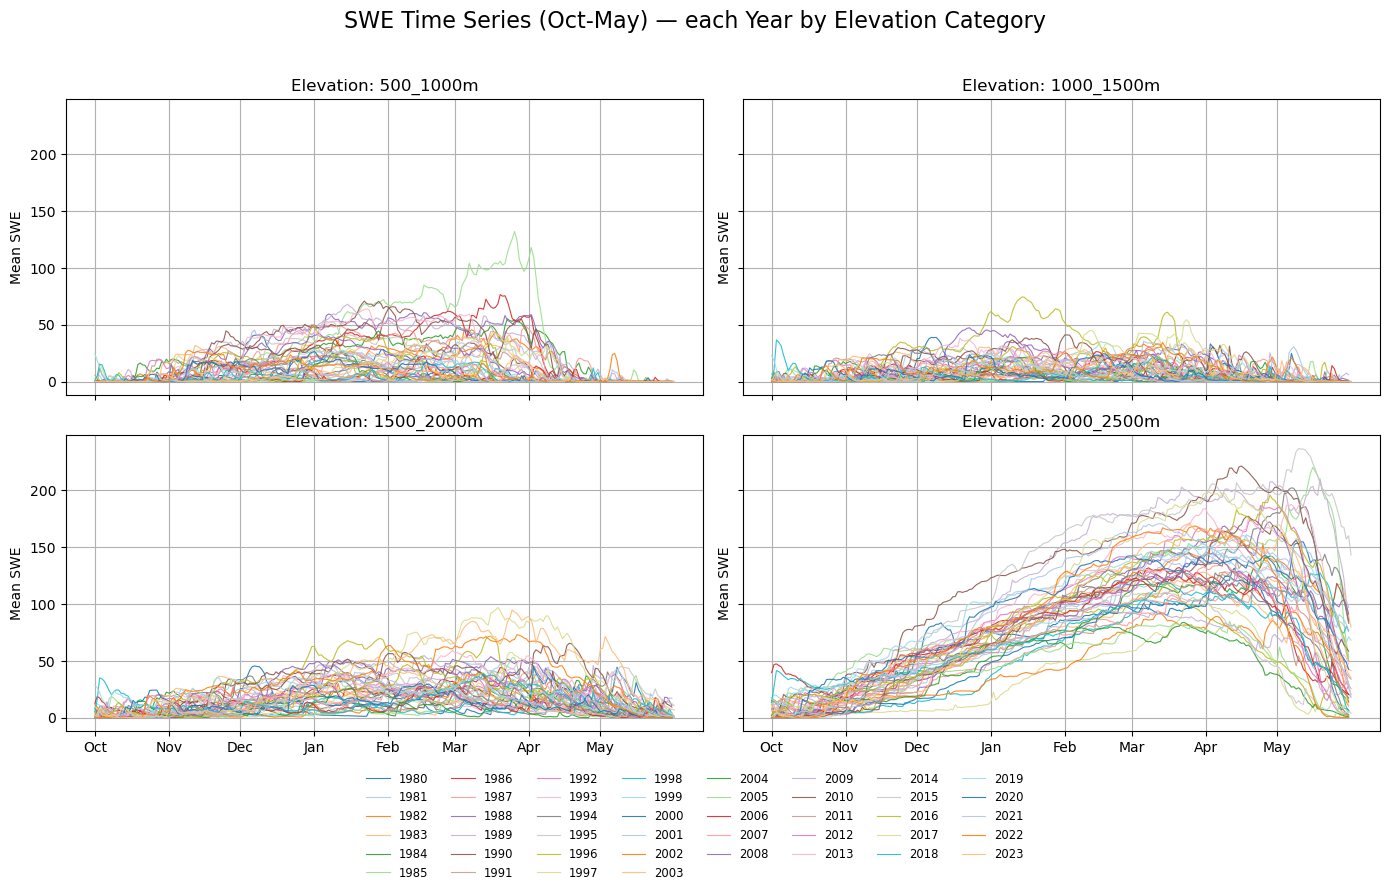

In [4]:
# Plot SWE for each season_year (Oct-May) per elevation category (up to 4 categories)
df_plot = winter_df.reset_index()  # date is a column here
cats_all = df_plot['Elevation_Category'].astype(str).unique()
cats = sorted(cats_all)[:4]  # up to 4 categories

# compute season start and season_day (days since Oct 1 of season_year)
df_plot['season_start'] = pd.to_datetime(df_plot['season_year'].astype(str) + '-10-01')
df_plot['season_day'] = (df_plot['date'] - df_plot['season_start']).dt.days

# aggregate: mean SWE across grid points for each Elevation_Category, season_year and season_day
swe_by_day = df_plot.groupby(['Elevation_Category', 'season_year', 'season_day'])['SWE'].mean()

# arrange categories in the requested order (keep only those present)
desired_order = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']
cats = [c for c in desired_order if c in list(cats_all)]

# fallback to previous selection if none of the desired categories are found
if not cats:
    cats = sorted(cats_all)[:4]

# ensure plot dir exists
config['plots'].mkdir(parents=True, exist_ok=True)

# create subplots
n = len(cats)
ncols = 2
nrows = (n + 1) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows), sharex=True, sharey=True)
axes_flat = axes.flatten() if hasattr(axes, "flatten") else [axes]

# color map for many years
cmap = plt.get_cmap('tab20')

for i, cat in enumerate(cats):
    ax = axes_flat[i]
    tbl = swe_by_day.loc[cat].unstack('season_year')  # index=season_day, columns=season_year
    tbl = tbl.sort_index(axis=1)  # ensure years sorted
    years = tbl.columns.tolist()
    for j, yr in enumerate(years):
        ax.plot(tbl.index, tbl[yr], label=str(yr), color=cmap(j % 20), lw=0.8, alpha=0.9)
    ax.set_title(f"Elevation: {cat}")
    ax.set_ylabel("Mean SWE")
    ax.grid(True)
    # prevent the per-axis legend (later "if i == 0: ax.legend(...)") from showing
    ax.legend = lambda *args, **kwargs: None
    # create a single figure-level legend (use the first axis which has all year lines)
    if i == 0:
        lines = ax.get_lines()
        labels = [ln.get_label() for ln in lines]
        # keep unique labels in order
        seen = set()
        uniq_handles = []
        uniq_labels = []
        for h, lbl in zip(lines, labels):
            if lbl in seen:
                continue
            seen.add(lbl)
            uniq_handles.append(h)
            uniq_labels.append(lbl)
        fig.legend(uniq_handles, uniq_labels, ncol=8, loc='lower center',
                   bbox_to_anchor=(0.5, -0.12), fontsize='small', frameon=False)
    if i == 0:
        ax.legend(ncol=4, fontsize='small', loc='upper left')

# hide unused axes
for j in range(len(cats), len(axes_flat)):
    axes_flat[j].set_visible(False)

# x-axis ticks: month labels from Oct -> May using a reference season_start
season_start_ref = pd.to_datetime('2000-10-01')
xticks_days = []
xtick_labels = []
for m in range(10, 13):
    dt = pd.to_datetime(f'2000-{m:02d}-01')
    xticks_days.append((dt - season_start_ref).days)
    xtick_labels.append(dt.strftime('%b'))
for m in range(1, 6):
    dt = pd.to_datetime(f'2001-{m:02d}-01')
    xticks_days.append((dt - season_start_ref).days)
    xtick_labels.append(dt.strftime('%b'))
for ax in axes_flat[:len(cats)]:
    ax.set_xticks(xticks_days)
    ax.set_xticklabels(xtick_labels)

fig.suptitle("SWE Time Series (Oct-May) — each Year by Elevation Category", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

out_file = config['plots'] / "swe_by_elevation_each_year_timeseries.png"
fig.savefig(out_file, dpi=150)
print(f"Saved figure to {out_file}")
plt.show()

# 1. Standardized SWEI Calculation

In [171]:
# Calculate daily SWE change considering each coordinate_id
# ensure rows are ordered by Grid_id, season_year and date so diff is computed in temporal order
swe_df = winter_df.reset_index().sort_values(['Grid_id', 'season_year', 'date']).set_index('date')

# compute next-day SWE change per grid and season (difference to next row within group)
swe_df['daily_SWE_change'] = swe_df.groupby(['Grid_id', 'season_year'])['SWE'].diff().shift(-1)
swe_df['daily_SWE_change'] = swe_df['daily_SWE_change'].fillna(0)
swe_df.loc[swe_df['daily_SWE_change'] < 0, 'daily_SWE_change'] = 0

# drop precipitation, mean_Temp, Max_Temp, Humidity, Flux, month, year, date columns if they exist
cols_to_drop = ['Precipitation', 'Mean_Temp', 'Max_Temp', 'Humidity', 'Flux', 'month', 'year', 'date','Surface_Pressure','Vwind']
existing = [c for c in cols_to_drop if c in swe_df.columns]
if existing:
	swe_df = swe_df.drop(columns=existing)

# save the updated DataFrame to a CSV file
out_file_swe_change = config['output_dir'] / 'For_SWEI_calculation.csv'
swe_df.to_csv(out_file_swe_change, index=True)
print(f"Saved daily SWE change data to: {out_file_swe_change}")

# Display the updated DataFrame
display(swe_df)


Saved daily SWE change data to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\For_SWEI_calculation.csv


,Grid_id,time,lon,lat,SWE,Elevation_Category,season_year,daily_SWE_change
date,,,,,,,,
1980-10-01,1,1980-10-01,-116.1380,51.3346,1.382812,2000_2500m,1980,0.367188
1980-10-02,1,1980-10-02,-116.1380,51.3346,1.750000,2000_2500m,1980,0.000000
1980-10-03,1,1980-10-03,-116.1380,51.3346,0.761230,2000_2500m,1980,0.000000
1980-10-04,1,1980-10-04,-116.1380,51.3346,0.382812,2000_2500m,1980,0.000000
1980-10-05,1,1980-10-05,-116.1380,51.3346,0.127930,2000_2500m,1980,0.000000
...,...,...,...,...,...,...,...,...
2024-05-27,257,2024-05-27,-111.6202,50.0960,0.000000,500_1000m,2023,0.000000
2024-05-28,257,2024-05-28,-111.6202,50.0960,0.000000,500_1000m,2023,0.000000
2024-05-29,257,2024-05-29,-111.6202,50.0960,0.000000,500_1000m,2023,0.000000


In [20]:
# 1. perturb zeros

swe_df['perturb_SWE'] = sswei.perturb_zeros(swe_df['daily_SWE_change'])

display(swe_df)

,Grid_id,time,lon,lat,SWE,Surface_Pressure,Vwind,Elevation_Category,season_year,daily_SWE_change,perturb_SWE
date,,,,,,,,,,,
1980-10-01,1,1980-10-01,-116.1380,51.3346,1.382812,792.058288,-0.488513,2000_2500m,1980,0.367188,3.671875e-01
1980-10-02,1,1980-10-02,-116.1380,51.3346,1.750000,796.678797,-0.443979,2000_2500m,1980,0.000000,3.761823e-06
1980-10-03,1,1980-10-03,-116.1380,51.3346,0.761230,792.348995,-0.062769,2000_2500m,1980,0.000000,1.485804e-06
1980-10-04,1,1980-10-04,-116.1380,51.3346,0.382812,786.060222,-0.065010,2000_2500m,1980,0.000000,1.593078e-06
1980-10-05,1,1980-10-05,-116.1380,51.3346,0.127930,790.957083,0.282685,2000_2500m,1980,0.000000,2.663139e-06
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,257,2024-05-27,-111.6202,50.0960,0.000000,927.905947,-1.362183,500_1000m,2023,0.000000,1.675517e-06
2024-05-28,257,2024-05-28,-111.6202,50.0960,0.000000,928.858805,5.194702,500_1000m,2023,0.000000,8.479621e-07
2024-05-29,257,2024-05-29,-111.6202,50.0960,0.000000,921.948881,2.026634,500_1000m,2023,0.000000,1.729353e-07


In [21]:
# 2. SWE Integration (fixed)

def integrate_season(group: pd.DataFrame) -> pd.Series:
    """
    Integrate SWE values over a season for each Grid_id / season_year / Elevation_Category.
    This version ensures we use datetime objects (either the index or 'time'/'date' columns)
    for arithmetic so we avoid str - str subtraction errors.
    """
    # Determine a datetime index to use
    if np.issubdtype(group.index.dtype, np.datetime64):
        time_index = group.index
    else:
        if 'time' in group.columns:
            time_index = pd.to_datetime(group['time'], errors='coerce')
        elif 'date' in group.columns:
            time_index = pd.to_datetime(group['date'], errors='coerce')
        else:
            raise ValueError("No datetime-like column found in group for integration")
    # drop rows with missing times or missing SWE
    valid_mask = (~pd.isna(time_index)) & (~pd.isna(group['SWE']))
    if not valid_mask.any():
        # return NaN integration if no valid data
        return pd.Series({
            'Grid_id': group['Grid_id'].iloc[0] if 'Grid_id' in group.columns else np.nan,
            'season_year': group['season_year'].iloc[0] if 'season_year' in group.columns else np.nan,
            'Elevation_Category': group['Elevation_Category'].iloc[0] if 'Elevation_Category' in group.columns else None,
            'total_SWE_integration': np.nan
        })
    time_index = pd.to_datetime(time_index[valid_mask])
    swe_vals = group['SWE'].values[valid_mask]

    # sort by time to ensure proper integration
    order = np.argsort(time_index)
    time_index = time_index[order]
    swe_vals = swe_vals[order]

    # compute days since start as numeric x values for trapz
    days_since_start = (time_index - time_index.min()).total_seconds() / 86400.0

    # Integrate SWE over the season
    total_swe_integration = trapz(swe_vals, days_since_start)

    return pd.Series({
        'Grid_id': group['Grid_id'].iloc[0],
        'season_year': group['season_year'].iloc[0],
        'Elevation_Category': group['Elevation_Category'].iloc[0],
        'total_SWE_integration': total_swe_integration
    })

# Apply the integration function to each group of Grid_id and season_year and Elevation_Category
SWE_integration = swe_df.groupby(['Grid_id', 'season_year', 'Elevation_Category']).apply(integrate_season).reset_index(drop=True)

display(SWE_integration)

,Grid_id,season_year,Elevation_Category,total_SWE_integration
0,1,1980,2000_2500m,30295.246322
1,1,1981,2000_2500m,34403.204364
2,1,1982,2000_2500m,34199.671012
3,1,1983,2000_2500m,27932.422855
4,1,1984,2000_2500m,26921.058586
...,...,...,...,...
11303,257,2019,500_1000m,571.779053
11304,257,2020,500_1000m,579.107177
11305,257,2021,500_1000m,283.044342
11306,257,2022,500_1000m,743.058776


In [22]:
# 3. Gringorten plotting position calculation
# Apply gringorten_probabilities grouped by coordinate_id
SWE_integration['gringorten_probability'] = SWE_integration.groupby('Grid_id')['total_SWE_integration'].transform(sswei.gringorten_probabilities)

# Display the updated DataFrame
display(SWE_integration)

,Grid_id,season_year,Elevation_Category,total_SWE_integration,gringorten_probability
0,1,1980,2000_2500m,30295.246322,0.556664
1,1,1981,2000_2500m,34403.204364,0.737987
2,1,1982,2000_2500m,34199.671012,0.692656
3,1,1983,2000_2500m,27932.422855,0.420671
4,1,1984,2000_2500m,26921.058586,0.352675
...,...,...,...,...,...
11303,257,2019,500_1000m,571.779053,0.239347
11304,257,2020,500_1000m,579.107177,0.262013
11305,257,2021,500_1000m,283.044342,0.012693
11306,257,2022,500_1000m,743.058776,0.466002


In [23]:
#4. Compute standardized SWEI
# Compute SSWEI grouped by coordinate_id
SWE_integration['SSWEI'] = SWE_integration.groupby('Grid_id')['gringorten_probability'].transform(sswei.compute_swei)

# Display the updated DataFrame
display(SWE_integration)

,Grid_id,season_year,Elevation_Category,total_SWE_integration,gringorten_probability,SSWEI
0,1,1980,2000_2500m,30295.246322,0.556664,0.142516
1,1,1981,2000_2500m,34403.204364,0.737987,0.637153
2,1,1982,2000_2500m,34199.671012,0.692656,0.503394
3,1,1983,2000_2500m,27932.422855,0.420671,-0.200177
4,1,1984,2000_2500m,26921.058586,0.352675,-0.378110
...,...,...,...,...,...,...
11303,257,2019,500_1000m,571.779053,0.239347,-0.708404
11304,257,2020,500_1000m,579.107177,0.262013,-0.637153
11305,257,2021,500_1000m,283.044342,0.012693,-2.235488
11306,257,2022,500_1000m,743.058776,0.466002,-0.085324


In [24]:
# Group by season_year and calculate the mean SSWEI for each year
# Group by Season_year and Elevation_Category, then pivot to have each elevation as a column
average_SSWEI_per_year = SWE_integration.groupby(['season_year', 'Elevation_Category'])['SSWEI'].mean().reset_index()
average_SSWEI_per_year = average_SSWEI_per_year.pivot(index='season_year', columns='Elevation_Category', values='SSWEI').reset_index()

# No need to rename columns here, as the pivot already gives correct column names

# Display the result
display(average_SSWEI_per_year)

Elevation_Category,season_year,1000_1500m,1500_2000m,2000_2500m,500_1000m
0,1980,-0.778473,-0.630553,-0.346771,-0.087648
1,1981,0.320094,-0.022423,0.090731,0.605933
2,1982,-0.942805,-0.050002,0.072459,0.618429
3,1983,-0.358285,-0.266688,-0.307029,0.474398
4,1984,-0.147442,0.176385,-0.214268,0.994070
5,1985,0.314323,0.575974,0.860058,1.250473
6,1986,-0.474813,0.062905,0.006162,0.569811
7,1987,-1.338402,-0.326762,-0.616191,0.386472
8,1988,0.898300,1.037102,0.378059,1.295822
9,1989,0.113604,1.057718,1.412421,1.065104


In [25]:
# 5. Classification

# Apply the classify_drought function to each value in the average_SSWEI column
# Apply the classify_drought function to each elevation column
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    average_SSWEI_per_year[f'Classification_{col}'] = average_SSWEI_per_year[col].apply(sswei.classify_drought)

# Do not rename columns here, as the DataFrame now has more columns after classification
# If you want to keep only certain columns, select them explicitly, e.g.:
# average_SSWEI_per_year = average_SSWEI_per_year[['Season_year', '1000_1500m', 'Classification_1000_1500m', ...]]

#remove decimal points from season year
average_SSWEI_per_year['season_year'] = average_SSWEI_per_year['season_year'].astype(int)

# Display the updated DataFrame
display(average_SSWEI_per_year)

Elevation_Category,season_year,1000_1500m,1500_2000m,2000_2500m,500_1000m,Classification_1000_1500m,Classification_1500_2000m,Classification_2000_2500m,Classification_500_1000m
0,1980,-0.778473,-0.630553,-0.346771,-0.087648,Moderate Drought,Moderate Drought,Near Normal,Near Normal
1,1981,0.320094,-0.022423,0.090731,0.605933,Near Normal,Near Normal,Near Normal,Abnormally Wet
2,1982,-0.942805,-0.050002,0.072459,0.618429,Moderate Drought,Near Normal,Near Normal,Abnormally Wet
3,1983,-0.358285,-0.266688,-0.307029,0.474398,Near Normal,Near Normal,Near Normal,Near Normal
4,1984,-0.147442,0.176385,-0.214268,0.994070,Near Normal,Near Normal,Near Normal,Abnormally Wet
5,1985,0.314323,0.575974,0.860058,1.250473,Near Normal,Abnormally Wet,Abnormally Wet,Moderately Wet
6,1986,-0.474813,0.062905,0.006162,0.569811,Near Normal,Near Normal,Near Normal,Abnormally Wet
7,1987,-1.338402,-0.326762,-0.616191,0.386472,Severe Drought,Near Normal,Moderate Drought,Near Normal
8,1988,0.898300,1.037102,0.378059,1.295822,Abnormally Wet,Moderately Wet,Near Normal,Moderately Wet
9,1989,0.113604,1.057718,1.412421,1.065104,Near Normal,Moderately Wet,Moderately Wet,Moderately Wet


In [13]:
# save final DataFrame
output_file = config['output_dir'] / 'SWEI_final.csv'
average_SSWEI_per_year.to_csv(output_file, index=False)
print(f"Final SWEI data saved to {output_file}")

Final SWEI data saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\SWEI_final.csv


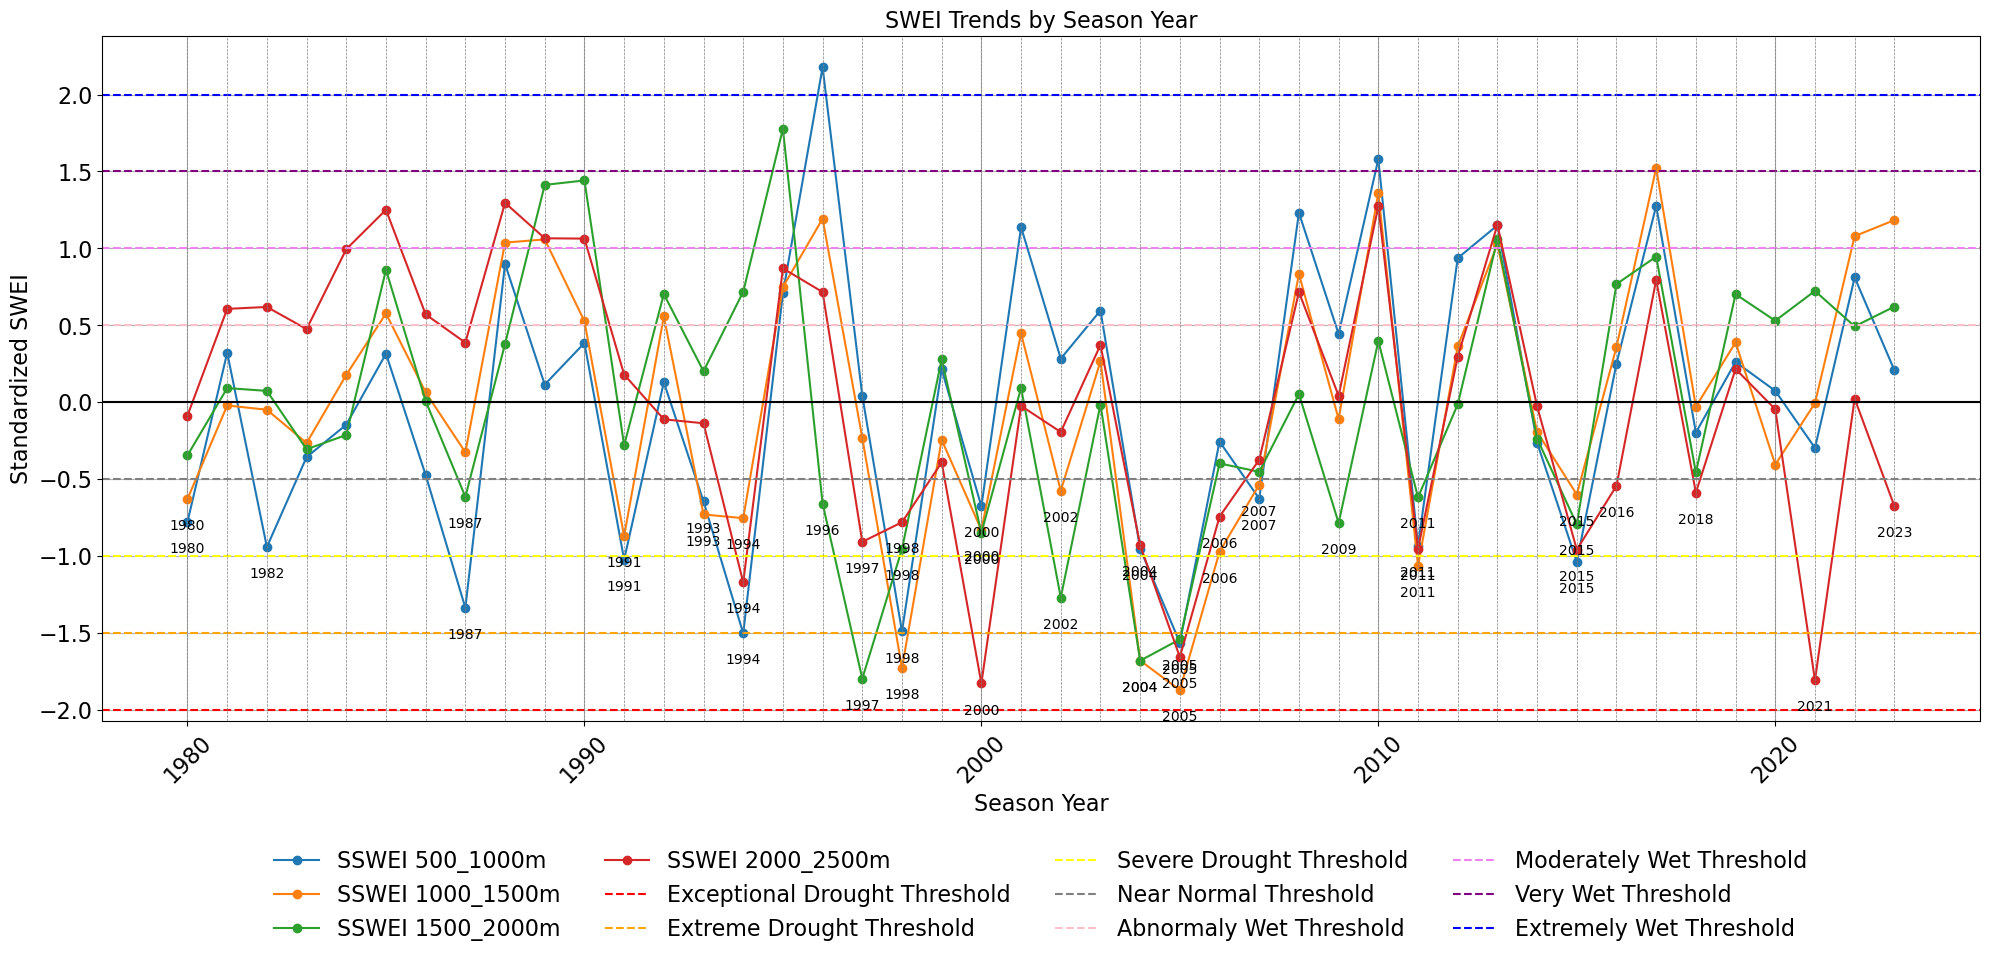

In [26]:
#6. Plotting the results
# Prepare data for plotting
plot_data = average_SSWEI_per_year.sort_values(by='season_year')
plt.figure(figsize=(20, 10))
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    plt.plot(plot_data['season_year'], plot_data[col], marker='o', label=f'SSWEI {col}')

# Add thresholds for drought classifications
plt.axhline(-2.0, color='r', linestyle='--', label='Exceptional Drought Threshold')
plt.axhline(-1.5, color='orange', linestyle='--', label='Extreme Drought Threshold')
plt.axhline(-1.0, color='yellow', linestyle='--', label='Severe Drought Threshold')
plt.axhline(-0.5, color='gray', linestyle='--', label='Near Normal Threshold')
plt.axhline(0.5, color='pink', linestyle='--', label='Abnormaly Wet Threshold')
plt.axhline(1.0, color='violet', linestyle='--', label='Moderately Wet Threshold')
plt.axhline(1.5, color='purple', linestyle='--', label='Very Wet Threshold')
plt.axhline(2.0, color='blue', linestyle='--', label='Extremely Wet Threshold')

# trend line
#z = np.polyfit(plot_data['Season_year'], plot_data['SSWEI'], 1)
#p = np.poly1d(z)
#plt.plot(plot_data['Season_year'],p(plot_data['Season_year']),"g--", label='trend line')

# Customize the plot
plt.title('SWEI Trends by Season Year',fontsize=16)
plt.xlabel('Season Year',fontsize=16)
plt.ylabel('Standardized SWEI',fontsize=16)
plt.xticks(rotation=45,fontsize=16)
plt.yticks(fontsize=16)
# put legend outside the plot right top 
plt.legend(['SSWEI 500_1000m', 'SSWEI 1000_1500m', 'SSWEI 1500_2000m', 'SSWEI 2000_2500m',
            'Exceptional Drought Threshold', 'Extreme Drought Threshold', 'Severe Drought Threshold',
            'Near Normal Threshold', 'Abnormaly Wet Threshold', 'Moderately Wet Threshold',
            'Very Wet Threshold', 'Extremely Wet Threshold'],
           loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4, fontsize=16, frameon=False)
# Add gridlines for each year
for year in plot_data['season_year'].unique():
    plt.axvline(year, color='gray', linestyle='--', linewidth=0.5)
# Add years to SSWEI < -0.5 for each elevation category
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    for i, row in plot_data.iterrows():
        if row[col] < -0.5:
            plt.text(row['season_year'], row[col] - 0.2, str(row['season_year']), fontsize=10, color='black', ha='center')
plt.grid()
plt.axhline(0, color='black', linewidth=1.5, linestyle='-', label='y=0')
plt.tight_layout()
plt.savefig(config['plots'] /  'SWEI_trends.png')
plt.show()
plt.close()

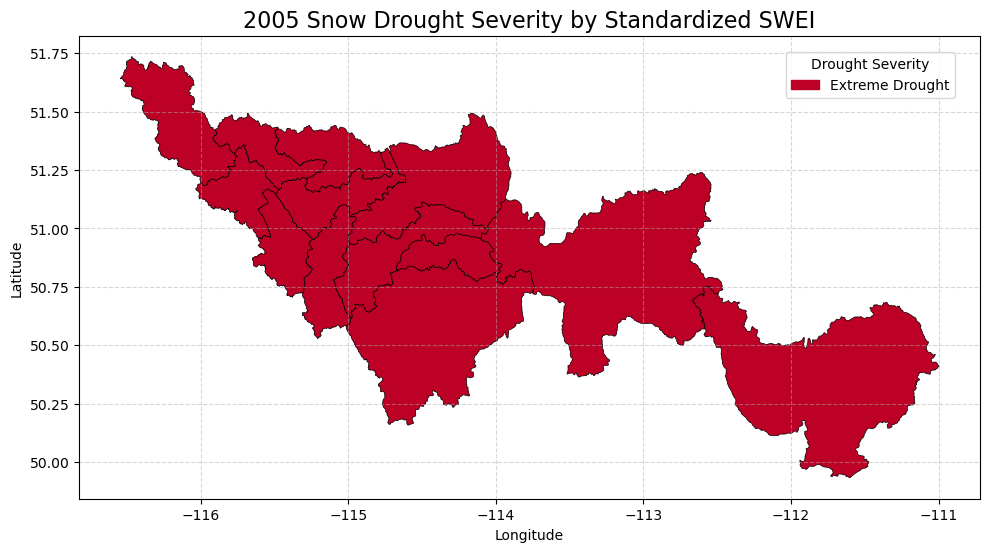

In [42]:
# Filter onset_to_peak for the year 2005
onset_to_peak_2005 = average_SSWEI_per_year[average_SSWEI_per_year['season_year'] == 2005]

# Get the classification for 2005 from plot_data
classifications_2005 = plot_data[plot_data['season_year'] == 2005][[
    'Classification_1000_1500m', 'Classification_1500_2000m', 'Classification_2000_2500m', 'Classification_500_1000m'
]].iloc[0]

# Map elevation category to classification
elev_class_map = {
    '1000_1500m': classifications_2005['Classification_1000_1500m'],
    '1500_2000m': classifications_2005['Classification_1500_2000m'],
    '2000_2500m': classifications_2005['Classification_2000_2500m'],
    '500_1000m': classifications_2005['Classification_500_1000m'],
}
# open Bow Basin shapefile
bow_basin = gpd.read_file(config['shapefile_dir'])

# Add drought classification to the Bow Basin shapefile
bow_basin['Drought_Classification'] = bow_basin['elev_class'].map(elev_class_map)

# Add drought classification to onset_to_peak_2005
onset_to_peak_2005 = onset_to_peak_2005.copy()

# detect elevation-category columns (common names from elev_order or exact matches)
elev_cols = [c for c in onset_to_peak_2005.columns if c in elev_order]

# if the DF is wide (columns per elevation) -> melt to long and map
if elev_cols and 'Elevation_Category' not in onset_to_peak_2005.columns:
    onset_to_peak_2005 = (
        onset_to_peak_2005.reset_index(drop=True)
        .melt(id_vars=['season_year'], value_vars=elev_cols,
              var_name='Elevation_Category', value_name='SSWEI')
    )
    onset_to_peak_2005['Drought_Classification'] = onset_to_peak_2005['Elevation_Category'].map(elev_class_map)
else:
    # if already long / has Elevation_Category column, map directly
    onset_to_peak_2005['Drought_Classification'] = onset_to_peak_2005['Elevation_Category'].map(elev_class_map)

# Define a color map for drought severity
severity_colors = {
    'Exceptional Drought': '#800026',
    'Extreme Drought': '#BD0026',
    'Severe Drought': "#D45F61",
    'Moderate Drought': "#E67D68",
    'Near Normal': '#FFEDA0',
    'Abnormally Wet': '#41B6C4',
    'Moderately Wet': '#1E90FF',
    'Very Wet': '#225EA8',
    'Extremely Wet': '#081D58'
}

# Assign colors to each polygon based on drought classification (fill missing with light gray)
bow_basin['color'] = bow_basin['Drought_Classification'].map(severity_colors).fillna('#dddddd')

# Plot the Bow Basin colored by drought severity
fig, ax = plt.subplots(figsize=(10, 8))
bow_basin.plot(ax=ax, color=bow_basin['color'], edgecolor='black', linewidth=0.5)

# Create legend patches only for severities present in the data (keeps legend small)

present_severities = [s for s in severity_colors.keys() if s in bow_basin['Drought_Classification'].unique()]
legend_patches = [mpatches.Patch(color=severity_colors[label], label=label) for label in present_severities]
if legend_patches:
    plt.legend(handles=legend_patches, title='Drought Severity', loc='upper right', bbox_to_anchor=(0.98, 0.98), frameon=True)

plt.title('2005 Snow Drought Severity by Standardized SWEI', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save to an existing path in config (use 'plots' to avoid missing key)
outpath = config.get('plots', config.get('output_dir'))
plt.savefig(Path(outpath) / 'bow_basin_drought_severity_2005.png', dpi=150)
plt.show()

# 2005 SWEI

In [104]:
# Extract season-based (season_year == 2005) and calendar-year (year == 2005) subsets from swe_df
if 'swe_df' not in globals():
    raise NameError("swe_df not found. Run the previous cells that create swe_df first.")

# season labeled 2005 (Oct 2005 - May 2006)
swe_df_2005_season = swe_df[swe_df['season_year'] == 2005].copy()

# calendar year 2005 (all rows whose datetime index or time column is in 2005)
if np.issubdtype(swe_df.index.dtype, np.datetime64):
    swe_df_2005_calendar = swe_df[swe_df.index.year == 2005].copy()
else:
    if 'time' in swe_df.columns:
        swe_df_2005_calendar = swe_df[pd.to_datetime(swe_df['time'], errors='coerce').dt.year == 2005].copy()
    elif 'date' in swe_df.columns:
        swe_df_2005_calendar = swe_df[pd.to_datetime(swe_df['date'], errors='coerce').dt.year == 2005].copy()
    else:
        swe_df_2005_calendar = pd.DataFrame()

print(f"Rows (season_year == 2005): {len(swe_df_2005_season)}")
print(f"Rows (calendar year 2005): {len(swe_df_2005_calendar)}")


display(swe_df_2005_season.head())

Rows (season_year == 2005): 62451
Rows (calendar year 2005): 62451


,Grid_id,time,lon,lat,SWE,Elevation_Category,season_year,daily_SWE_change
date,,,,,,,,
2005-10-01,1,2005-10-01,-116.138,51.3346,11.274902,2000_2500m,2005,3.475098
2005-10-02,1,2005-10-02,-116.138,51.3346,14.750000,2000_2500m,2005,0.125000
2005-10-03,1,2005-10-03,-116.138,51.3346,14.875000,2000_2500m,2005,0.750000
2005-10-04,1,2005-10-04,-116.138,51.3346,15.625000,2000_2500m,2005,0.000000
2005-10-05,1,2005-10-05,-116.138,51.3346,14.875000,2000_2500m,2005,0.000000


In [105]:
# perturb daily_SWE_change for both subsets
swe_df_2005_season['perturb_SWE'] = sswei.perturb_zeros(swe_df_2005_season['daily_SWE_change'])

display(swe_df_2005_season.head())


,Grid_id,time,lon,lat,SWE,Elevation_Category,season_year,daily_SWE_change,perturb_SWE
date,,,,,,,,,
2005-10-01,1,2005-10-01,-116.138,51.3346,11.274902,2000_2500m,2005,3.475098,3.475098
2005-10-02,1,2005-10-02,-116.138,51.3346,14.750000,2000_2500m,2005,0.125000,0.125000
2005-10-03,1,2005-10-03,-116.138,51.3346,14.875000,2000_2500m,2005,0.750000,0.750000
2005-10-04,1,2005-10-04,-116.138,51.3346,15.625000,2000_2500m,2005,0.000000,0.000009
2005-10-05,1,2005-10-05,-116.138,51.3346,14.875000,2000_2500m,2005,0.000000,0.000010


In [118]:
# monthly integration of SWE for swe_df_2005_season per Grid_id
# outputs monthly_swe_integration (Grid_id, season_year, month, month_label, n_obs, SWE_integration)
if 'swe_df_2005_season' not in globals():
    raise NameError("swe_df_2005_season not found. Run the cells that create it first.")

df = swe_df_2005_season.reset_index().rename(columns={'date': 'date'})  # bring date back as column

# ensure we have a datetime 'date' column and a numeric 'month' column for grouping
if 'date' not in df.columns or not np.issubdtype(df['date'].dtype, np.datetime64):
    if 'time' in df.columns:
        df['date'] = pd.to_datetime(df['time'], errors='coerce')
    else:
        # reset_index above should have created 'date' from the index name; try converting it anyway
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

if df['date'].isna().all():
    raise KeyError("No valid datetime values found in 'date'/'time' columns of swe_df_2005_season")

df['month'] = df['date'].dt.month

def integrate_month_group(g: pd.DataFrame) -> pd.Series:
    # expect g to have columns: date, SWE
    times = pd.to_datetime(g['date'], errors='coerce')
    swe = g['SWE'].astype(float)
    valid = (~times.isna()) & (~swe.isna())
    if valid.sum() < 2:
        return pd.Series({
            'n_obs': int(valid.sum()),
            'SWE_integration': np.nan
        })
    times = times[valid].sort_values()
    swe_vals = swe[valid].values[np.argsort(times)]
    # compute days since month start for numeric x axis
    days = (times - times.min()).dt.total_seconds() / 86400.0
    total = trapz(swe_vals, days)
    return pd.Series({
        'n_obs': int(len(swe_vals)),
        'SWE_integration': float(total)
    })

grouped = df.groupby(['Grid_id', 'season_year', 'month','Elevation_Category'], observed=True)
monthly_swe_integration = grouped.apply(integrate_month_group).reset_index()

# add month_label
month_labels = {10:'Oct',11:'Nov',12:'Dec',1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May'}
monthly_swe_integration['month_label'] = monthly_swe_integration['month'].map(month_labels)

# reorder columns
monthly_swe_integration = monthly_swe_integration[['Grid_id','season_year','month','month_label','n_obs','Elevation_Category','SWE_integration']]

# save and display
out_file = config['output_dir'] / 'monthly_SWE_integration_by_grid_2005.csv'
monthly_swe_integration.to_csv(out_file, index=False)
print(f"Saved monthly SWE integration per Grid_id to: {out_file}")
display(monthly_swe_integration.head())

Saved monthly SWE integration per Grid_id to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SWE_integration_by_grid_2005.csv


,Grid_id,season_year,month,month_label,n_obs,Elevation_Category,SWE_integration
0,1,2005,1,Jan,31.0,2000_2500m,2861.312500
1,1,2005,2,Feb,28.0,2000_2500m,3349.937500
2,1,2005,3,Mar,31.0,2000_2500m,4379.125000
3,1,2005,4,Apr,30.0,2000_2500m,4084.704590
4,1,2005,5,May,31.0,2000_2500m,1579.161132


In [121]:
# Apply gringorten_probabilities grouped by coordinate_id
monthly_swe_integration['gringorten_probability'] = monthly_swe_integration.groupby('Grid_id')['SWE_integration'].transform(sswei.gringorten_probabilities)
# Display the updated DataFrame
display(monthly_swe_integration)

,Grid_id,season_year,month,month_label,n_obs,Elevation_Category,SWE_integration,gringorten_probability
0,1,2005,1,Jan,31.0,2000_2500m,2861.312500,0.561576
1,1,2005,2,Feb,28.0,2000_2500m,3349.937500,0.684729
2,1,2005,3,Mar,31.0,2000_2500m,4379.125000,0.931034
3,1,2005,4,Apr,30.0,2000_2500m,4084.704590,0.807882
4,1,2005,5,May,31.0,2000_2500m,1579.161132,0.315271
...,...,...,...,...,...,...,...,...
2051,257,2005,4,Apr,30.0,500_1000m,0.260742,0.315271
2052,257,2005,5,May,31.0,500_1000m,0.000000,0.068966
2053,257,2005,10,Oct,31.0,500_1000m,0.251648,0.192118
2054,257,2005,11,Nov,30.0,500_1000m,5.447998,0.438424


In [122]:
# 4. Compute standardized SWEI
# Compute SSWEI grouped by coordinate_id
monthly_swe_integration['SSWEI'] = monthly_swe_integration.groupby('Grid_id')['gringorten_probability'].transform(sswei.compute_swei)

# Display the updated DataFrame
display(monthly_swe_integration)

,Grid_id,season_year,month,month_label,n_obs,Elevation_Category,SWE_integration,gringorten_probability,SSWEI
0,1,2005,1,Jan,31.0,2000_2500m,2861.312500,0.561576,0.154967
1,1,2005,2,Feb,28.0,2000_2500m,3349.937500,0.684729,0.480964
2,1,2005,3,Mar,31.0,2000_2500m,4379.125000,0.931034,1.483540
3,1,2005,4,Apr,30.0,2000_2500m,4084.704590,0.807882,0.870117
4,1,2005,5,May,31.0,2000_2500m,1579.161132,0.315271,-0.480964
...,...,...,...,...,...,...,...,...,...
2051,257,2005,4,Apr,30.0,500_1000m,0.260742,0.315271,-0.480964
2052,257,2005,5,May,31.0,500_1000m,0.000000,0.068966,-1.483540
2053,257,2005,10,Oct,31.0,500_1000m,0.251648,0.192118,-0.870117
2054,257,2005,11,Nov,30.0,500_1000m,5.447998,0.438424,-0.154967


In [127]:
# Group by month and Elevation_Category, then pivot to have each elevation as a column
average_SSWEI = monthly_swe_integration.groupby(['month', 'Elevation_Category'])['SSWEI'].mean().reset_index()
average_SSWEI = average_SSWEI.pivot(index='month', columns='Elevation_Category', values='SSWEI').reset_index()

out_2005_long = config['output_dir'] / 'monthly_SWEI_2005_long.csv'
average_SSWEI.to_csv(out_2005_long, index=False)
print(f"Saved monthly SWEI for 2005 (long) to: {out_2005_long}")
# Display the result
display(average_SSWEI)

Saved monthly SWEI for 2005 (long) to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SWEI_2005_long.csv


Elevation_Category,month,1000_1500m,1500_2000m,2000_2500m,500_1000m
0,1,-0.082649,-0.070957,0.245064,0.417232
1,2,0.627864,0.169559,0.427731,0.429899
2,3,1.463092,1.422198,1.456277,1.478063
3,4,-0.618158,-0.341891,0.558838,-0.767177
4,5,-1.409226,-1.219167,-0.925401,-1.353153
5,10,-0.807238,-0.929162,-1.275402,-0.714291
6,11,0.104382,0.099932,-0.524131,-0.149433
7,12,0.721932,0.869488,0.037024,0.658860


# SPI calculation

In [44]:
# Extract precipitation time series for SPI calculations (monthly and seasonal totals)
# Assumes `winter_df` (filtered to Oct-May) already exists in the notebook.

df_prec = winter_df.reset_index()  # bring date back as a column if it's the index

# keep only the requested columns (rename to lowercase names for consistency)
_keep = ['date', 'Grid_id', 'lon', 'lat', 'Precipitation', 'Elevation_Category', 'month', 'season_year']
_available = [c for c in _keep if c in df_prec.columns]
df_prec = df_prec[_available].rename(columns={
    'Grid_id': 'Grid_id',
    'Precipitation': 'Precipitation',
    'Elevation_Category': 'Elevation_Category',
    'season_year': 'Season_year'
})

# ensure date is datetime
df_prec['date'] = pd.to_datetime(df_prec['date'], errors='coerce')

display(df_prec.head())

,date,Grid_id,lon,lat,Precipitation,Elevation_Category,month,Season_year
0,1980-10-10,1,-116.1380,51.3346,0.009879,2000_2500m,10,1980
1,1983-10-12,2,-116.1875,51.4191,0.023846,2000_2500m,10,1983
2,1980-12-11,2,-116.1875,51.4191,4.578907,2000_2500m,12,1980
3,1982-10-29,2,-116.1875,51.4191,1.777088,2000_2500m,10,1982
4,1982-01-18,2,-116.1875,51.4191,1.890419,2000_2500m,1,1981


In [45]:
# Calculate monthly precipitation for each season year and grid point
monthly_precip = (
    df_prec
    .groupby(['Grid_id', 'Season_year', pd.Grouper(key='date', freq='M')])['Precipitation']
    .sum()
    .reset_index()
)

# Add elevation category for each Grid_id
# Get unique mapping from Grid_id to Elevation_Category
elevation_map = df_prec[['Grid_id', 'Elevation_Category']].drop_duplicates().set_index('Grid_id')['Elevation_Category']
monthly_precip['Elevation_Category'] = monthly_precip['Grid_id'].map(elevation_map)

display(monthly_precip.head())

,Grid_id,Season_year,date,Precipitation,Elevation_Category
0,1,1980,1980-10-31,15.461886,2000_2500m
1,1,1980,1980-11-30,50.295086,2000_2500m
2,1,1980,1980-12-31,108.955549,2000_2500m
3,1,1980,1981-01-31,13.916898,2000_2500m
4,1,1980,1981-02-28,38.431036,2000_2500m


In [46]:
# Calculate monthly average precipitation for each Elevation_Category, Season_year, and month
monthly_avg = (
    monthly_precip
    .groupby(['Elevation_Category', 'Season_year', monthly_precip['date']])['Precipitation']
    .mean()
    .unstack(level=0)  # Elevation_Category as columns
)

# Rename columns to match the format "2000-2500m_P"
monthly_avg.columns = [f"{col}_P" for col in monthly_avg.columns]

display(monthly_avg.head(10))

1000_1500m_P  1500_2000m_P  2000_2500m_P  500_1000m_P
Season_year date                                                             
1980        1980-10-31     23.722882     32.100595     23.455035    27.613888
            1980-11-30     23.173287     32.786186     52.304052    12.598151
            1980-12-31     24.672522     39.349471     94.355993    27.466716
            1981-01-31      6.245697      9.145041     11.316449     8.226255
            1981-02-28      8.437483     13.018755     29.459216     4.767321
            1981-03-31     15.564112     10.314856     14.930461    22.119542
            1981-04-30      7.126947     12.134646     29.451566     7.069899
            1981-05-31    133.068552    162.022685     95.782016    96.181287
1981        1981-10-31     20.885100     15.466855     33.907494    22.720848
            1981-11-30      4.466762      6.709451     12.339459     7.268729

In [13]:
# Save the combined data to a CSV file
output_file_precip = config['output_dir'] / 'bow_casr_winter_precipitation_data.csv'
monthly_avg.to_csv(output_file_precip, index=True)


In [56]:
import warnings

# Monthly SPI calculation (new cell)
# Uses monthly_precip if available; otherwise rebuilds it from df_prec.

warnings.filterwarnings("ignore", category=RuntimeWarning)

# months considered (Oct -> May)
months_order = [10, 11, 12, 1, 2, 3, 4, 5]
month_labels = {10:'Oct',11:'Nov',12:'Dec',1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May'}

# Ensure monthly_precip exists (it should from earlier cells); if not, recreate from df_prec
if 'monthly_precip' not in globals():
    # df_prec expected to exist (created earlier from winter_df)
    monthly_precip = (
        df_prec
        .groupby(['Grid_id', 'Season_year', pd.Grouper(key='date', freq='M')])['Precipitation']
        .sum()
        .reset_index()
    )
    elevation_map = df_prec[['Grid_id', 'Elevation_Category']].drop_duplicates().set_index('Grid_id')['Elevation_Category']
    monthly_precip['Elevation_Category'] = monthly_precip['Grid_id'].map(elevation_map)

# add month column
monthly_precip['month'] = pd.to_datetime(monthly_precip['date']).dt.month

# Aggregate across grid points to obtain area-mean monthly precipitation per Elevation_Category
agg = (
    monthly_precip.loc[monthly_precip['month'].isin(months_order)]
    .groupby(['Elevation_Category', 'Season_year', 'month'], observed=True)['Precipitation']
    .mean()
    .reset_index()
)

# season range to anchor index order
season_range = sorted(agg['Season_year'].unique())

rows = []
for elev in sorted(agg['Elevation_Category'].unique()):
    for m in months_order:
        ser = agg.loc[(agg['Elevation_Category'] == elev) & (agg['month'] == m), ['Season_year', 'Precipitation']].set_index('Season_year').reindex(season_range)
        vals = ser['Precipitation'].values.astype(float)
        # prepare output container for this elev-month
        spi_vals = np.full(len(season_range), np.nan)
        # fit gamma to positive precipitation values (require minimum samples)
        valid_idx = ~np.isnan(vals) & (vals > 0)
        if valid_idx.sum() >= 10:
            try:
                shape, loc, scale = gamma.fit(vals[valid_idx], floc=0)
                # compute cdf for each season value (NaN stays NaN)
                cdf = np.full(len(vals), np.nan)
                for i, v in enumerate(vals):
                    if not np.isnan(v):
                        # gamma.cdf handles zero/positive values; clip later
                        cdf[i] = gamma.cdf(v, shape, loc=loc, scale=scale)
                # avoid 0/1
                cdf = np.asarray(cdf, dtype=float)
                mask = ~np.isnan(cdf)
                cdf[mask] = np.clip(cdf[mask], 1e-6, 1 - 1e-6)
                spi_vals[mask] = norm.ppf(cdf[mask])
            except Exception:
                # fallback empirical plotting position
                ranked = pd.Series(vals).rank(method='average', na_option='keep').values
                n = np.sum(~np.isnan(vals))
                if n > 0:
                    pp = ranked / (n + 1)
                    mask = ~np.isnan(vals)
                    spi_vals[mask] = norm.ppf(np.clip(pp[mask], 1e-6, 1 - 1e-6))
        else:
            # not enough data -> leave NaNs
            pass

        for yr, spi_val in zip(season_range, spi_vals):
            rows.append({
                'Season_year': yr,
                'Elevation_Category': elev,
                'month': m,
                'month_label': month_labels[m],
                'Precipitation': float(agg.loc[(agg['Elevation_Category']==elev)&(agg['Season_year']==yr)&(agg['month']==m), 'Precipitation'].squeeze()) if ((agg['Elevation_Category']==elev)&(agg['Season_year']==yr)&(agg['month']==m)).any() else np.nan,
                'SPI': float(spi_val) if not np.isnan(spi_val) else np.nan
            })

monthly_spi = pd.DataFrame(rows)

# pivot to wide format if useful: index Season_year, columns like (Elevation, month)
monthly_spi_wide = monthly_spi.pivot_table(index='Season_year', columns=['Elevation_Category', 'month'], values='SPI')

# Save results
out_csv = config['output_dir'] / 'monthly_SPI_by_elevation.csv'
monthly_spi.to_csv(out_csv, index=False)
out_csv_wide = config['output_dir'] / 'monthly_SPI_by_elevation_wide.csv'
monthly_spi_wide.to_csv(out_csv_wide)

print(f"Monthly SPI computed. Long CSV: {out_csv}, Wide CSV: {out_csv_wide}")
display(monthly_spi.head())

Monthly SPI computed. Long CSV: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SPI_by_elevation.csv, Wide CSV: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SPI_by_elevation_wide.csv


,Season_year,Elevation_Category,month,month_label,Precipitation,SPI
0,1980,1000_1500m,10,Oct,23.722882,0.298526
1,1981,1000_1500m,10,Oct,20.885100,0.075540
2,1982,1000_1500m,10,Oct,5.255342,-1.856725
3,1983,1000_1500m,10,Oct,5.152061,-1.879497
4,1984,1000_1500m,10,Oct,29.395997,0.696169


In [58]:
# Filter monthly_spi for Season_year == 2005, display and save
if 'monthly_spi' not in globals():
    raise NameError("monthly_spi not found. Run the monthly SPI computation cell first.")

monthly_spi_2005 = monthly_spi[monthly_spi['Season_year'] == 2005].reset_index(drop=True)
display(monthly_spi_2005)

out_csv = config['output_dir'] / 'monthly_SPI_2005.csv'
monthly_spi_2005.to_csv(out_csv, index=False)
print(f"Saved filtered monthly SPI for 2005 to: {out_csv}")

,Season_year,Elevation_Category,month,month_label,Precipitation,SPI
0,2005,1000_1500m,10,Oct,19.361433,-0.052669
1,2005,1000_1500m,11,Nov,16.813028,0.131721
2,2005,1000_1500m,12,Dec,4.272242,-1.209708
3,2005,1000_1500m,1,Jan,7.627983,-0.349224
4,2005,1000_1500m,2,Feb,16.604584,0.466405
5,2005,1000_1500m,3,Mar,11.131235,-0.891061
6,2005,1000_1500m,4,Apr,25.034489,-0.159193
7,2005,1000_1500m,5,May,46.417620,-0.376534
8,2005,1500_2000m,10,Oct,27.055029,-0.013912
9,2005,1500_2000m,11,Nov,25.732530,0.276616


Saved filtered monthly SPI for 2005 to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SPI_2005.csv


In [79]:
# Normalize SPI values in monthly_spi_2005 to the range [-1, 1] per elevation category
# (uses MinMaxScaler already imported earlier in the notebook)

# Ensure monthly_spi_2005 exists; if not, create it from monthly_spi
if 'monthly_spi_2005' not in globals():
    if 'monthly_spi' in globals():
        monthly_spi_2005 = monthly_spi[monthly_spi['Season_year'] == 2005].reset_index(drop=True)
    else:
        raise NameError("monthly_spi not found. Run the monthly SPI computation cell first.")

# copy to avoid modifying original unintentionally
monthly_spi_2005 = monthly_spi_2005.copy()

# Prepare output column
monthly_spi_2005['SPI_normalized'] = np.nan

scaler = MinMaxScaler(feature_range=(-1, 1))

for elev in monthly_spi_2005['Elevation_Category'].unique():
    mask = monthly_spi_2005['Elevation_Category'] == elev
    vals = monthly_spi_2005.loc[mask, 'SPI'].to_numpy().astype(float)

    # handle cases with insufficient valid values
    valid_mask = ~np.isnan(vals)
    if valid_mask.sum() == 0:
        monthly_spi_2005.loc[mask, 'SPI_normalized'] = np.nan
        continue
    if valid_mask.sum() == 1:
        # single value -> map to 0
        monthly_spi_2005.loc[mask, 'SPI_normalized'] = 0.0
        continue

    # scale only the valid entries
    try:
        scaled = vals.copy()
        scaled_valid = scaler.fit_transform(vals[valid_mask].reshape(-1, 1)).ravel()
        scaled[valid_mask] = scaled_valid
        monthly_spi_2005.loc[mask, 'SPI_normalized'] = scaled
    except Exception:
        # fallback: z-score then clip to [-1,1]
        series = pd.Series(vals)
        z = (series - series.mean()) / (series.std(ddof=0) if series.std(ddof=0) != 0 else 1.0)
        monthly_spi_2005.loc[mask, 'SPI_normalized'] = np.clip(z, -1, 1)

# Save and display
out_file = config['output_dir'] / 'monthly_SPI_2005_normalized.csv'
monthly_spi_2005.to_csv(out_file, index=False)
print(f"Saved normalized monthly SPI for 2005 to: {out_file}")
display(monthly_spi_2005)

Saved normalized monthly SPI for 2005 to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SPI_2005_normalized.csv


,Season_year,Elevation_Category,month,month_label,Precipitation,SPI,SPI_normalized
0,2005,1000_1500m,10,Oct,19.361433,-0.052669,0.380621
1,2005,1000_1500m,11,Nov,16.813028,0.131721,0.600642
2,2005,1000_1500m,12,Dec,4.272242,-1.209708,-1.000000
3,2005,1000_1500m,1,Jan,7.627983,-0.349224,0.026761
4,2005,1000_1500m,2,Feb,16.604584,0.466405,1.000000
5,2005,1000_1500m,3,Mar,11.131235,-0.891061,-0.619779
6,2005,1000_1500m,4,Apr,25.034489,-0.159193,0.253513
7,2005,1000_1500m,5,May,46.417620,-0.376534,-0.005826
8,2005,1500_2000m,10,Oct,27.055029,-0.013912,0.696911
9,2005,1500_2000m,11,Nov,25.732530,0.276616,1.000000


2025-11-06 11:59:24,651 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 11:59:24,654 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 11:59:24,657 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 11:59:24,660 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 11:59:24,662 - INFO - Using categorical units to plot a list of strings that are all parsable as 

Saved 2005 monthly SPI plot to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\monthly_SPI_2005_plot.png


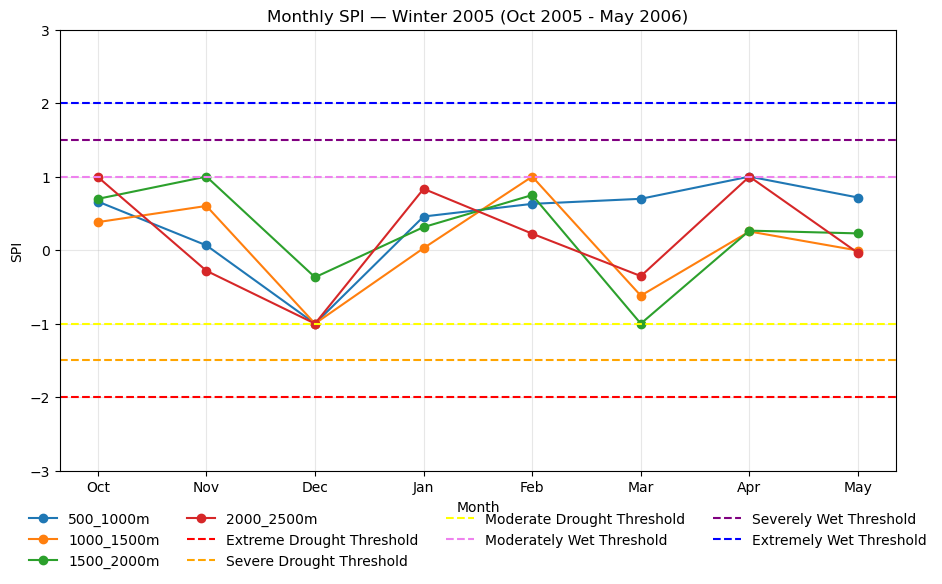

In [80]:
# Plot monthly SPI for Season_year == 2005 (Oct 2005 - May 2006)
#df2005 = monthly_spi[monthly_spi_2005['Season_year'] == 2005].copy()

# desired months and labels (Oct -> May)
months_order = [10, 11, 12, 1, 2, 3, 4, 5]
month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']

# pivot so columns are elevation categories, index is month
pivot_2005 = monthly_spi_2005.pivot(index='month', columns='Elevation_Category', values='SPI_normalized').reindex(months_order)

# elevation plotting order (keep only those present)
elev_order = [e for e in ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m'] if e in pivot_2005.columns]

plt.figure(figsize=(10, 6))
for elev in elev_order:
    plt.plot(month_labels, pivot_2005[elev].values, marker='o', label=f'{elev}')

# drought thresholds
plt.axhline(-2.0, color='r', linestyle='--', label='Extreme Drought Threshold')
plt.axhline(-1.5, color='orange', linestyle='--', label='Severe Drought Threshold')
plt.axhline(-1.0, color='yellow', linestyle='--', label='Moderate Drought Threshold')
plt.axhline(1.0, color='violet', linestyle='--', label='Moderately Wet Threshold')
plt.axhline(1.5, color='purple', linestyle='--', label='Severely Wet Threshold')
plt.axhline(2.0, color='blue', linestyle='--', label='Extremely Wet Threshold')


plt.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.250), frameon=False)
plt.title('Monthly SPI — Winter 2005 (Oct 2005 - May 2006)')
plt.xlabel('Month')
plt.ylabel('SPI')
plt.grid(alpha=0.3)
plt.ylim(-3, 3)
plt.tight_layout()

out_path = config['plots'] / 'monthly_SPI_2005_plot.png'
plt.savefig(out_path, dpi=150)
print(f"Saved 2005 monthly SPI plot to: {out_path}")
plt.show()

SPI - 8

In [47]:
# Group by season and sum the precipitation for each column
seasonal_precip = monthly_avg.groupby('Season_year').sum(numeric_only=True)

display(seasonal_precip)


,1000_1500m_P,1500_2000m_P,2000_2500m_P,500_1000m_P
Season_year,,,,
1980,242.011482,310.872235,351.054789,206.043058
1981,171.030216,193.174389,291.108212,160.440271
1982,156.795298,205.542866,243.835041,117.648657
1983,137.950856,189.299702,258.186900,110.003974
1984,116.997037,184.783056,244.739935,140.387278
1985,164.864539,219.291349,331.202378,119.285645
1986,100.427064,157.675500,258.874716,91.564115
1987,87.722122,149.274611,258.678127,54.590393
1988,152.237207,211.979476,276.572095,116.466092


In [48]:
# Calculate SPI for each elevation column and season year
spi_results = {}

for col in seasonal_precip.columns:
    # Drop NaNs and non-positive values for SPI calculation
    precip = seasonal_precip[col].dropna()
    precip = precip[precip > 0]  # Only positive values
    if len(precip) < 10:  # Not enough data to fit
        spi_results[col.replace('_P', '_SPI')] = [float('nan')] * len(seasonal_precip)
        continue
    shape, loc, scale = gamma.fit(precip, floc=0)
    cdf = gamma.cdf(seasonal_precip[col], shape, loc=loc, scale=scale)
    #cdf = cdf.clip(1e-10, 1 - 1e-10)  # Avoid exactly 0 or 1
    spi = norm.ppf(cdf)
    spi_results[col.replace('_P', '_SPI')] = spi

# Combine SPI results into a DataFrame
spi_df = pd.DataFrame(spi_results, index=seasonal_precip.index)

display(spi_df.tail(20))

,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI
Season_year,,,,
2004,-0.846991,-0.911534,-0.699333,-1.368231
2005,-0.957269,-1.322759,-0.873862,0.276581
2006,1.061388,0.127216,1.354495,1.869389
2007,0.886514,1.034454,0.506064,-0.058830
2008,-0.022649,-0.158597,-0.562560,-0.359796
2009,0.547848,-0.138778,-1.395304,2.081513
2010,2.072322,1.576848,0.885386,1.605807
2011,0.798770,0.768847,1.275185,1.035127
2012,1.523647,1.419827,1.029248,1.489081


In [21]:
# save final DataFrame
output_file_spi = config['output_dir'] / 'SPI_final.csv'
spi_df.to_csv(output_file_spi, index=True)


Saved monthly SWEI plot for 2023 to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\SPI_8.png


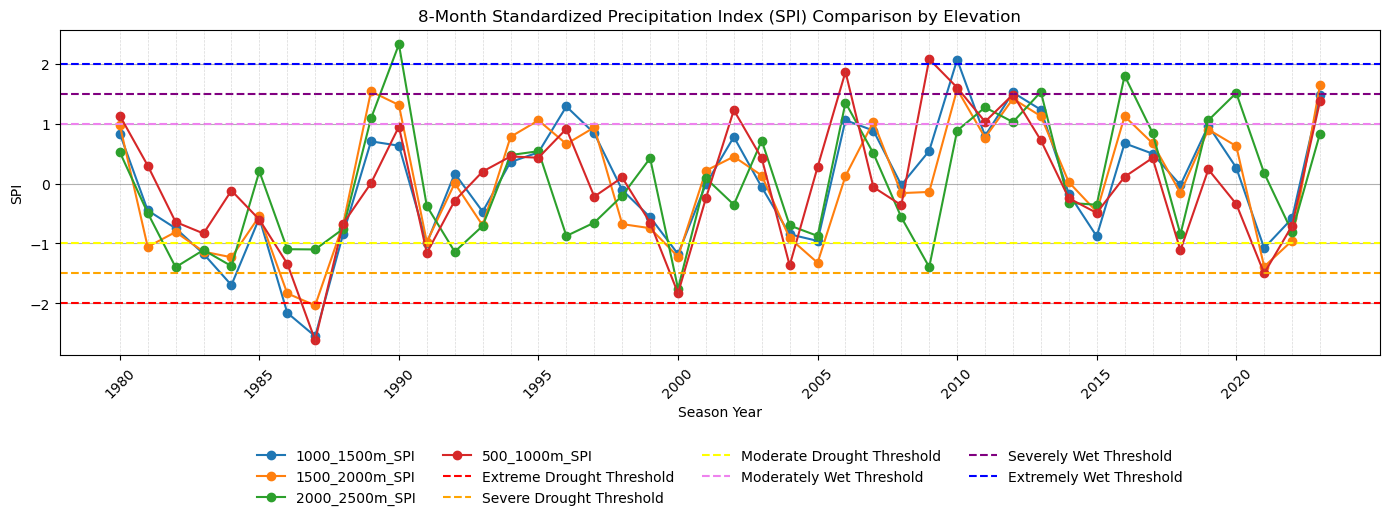

In [53]:
# Plot all SPI columns from spi_df on the same graph for comparison
plt.figure(figsize=(14, 6))
for col in spi_df.columns:
    plt.plot(spi_df.index, spi_df[col], marker='o', label=col)

# Add thresholds for drought classifications
plt.axhline(-2.0, color='r', linestyle='--', label='Extreme Drought Threshold')
plt.axhline(-1.5, color='orange', linestyle='--', label='Severe Drought Threshold')
plt.axhline(-1.0, color='yellow', linestyle='--', label='Moderate Drought Threshold')
plt.axhline(1.0, color='violet', linestyle='--', label='Moderately Wet Threshold')
plt.axhline(1.5, color='purple', linestyle='--', label='Severely Wet Threshold')
plt.axhline(2.0, color='blue', linestyle='--', label='Extremely Wet Threshold')

plt.xlabel('Season Year')
plt.ylabel('SPI')
plt.title('8-Month Standardized Precipitation Index (SPI) Comparison by Elevation')
plt.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.50), frameon=False)
plt.grid(True, axis='y')
for year in spi_df.index:
    plt.axvline(x=year, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.xticks(
    ticks=spi_df.index[::5],  # every 5th year
    labels=spi_df.index[::5],
    rotation=45
)
out_path = config['plots'] / 'SPI_8.png'
plt.tight_layout()
plt.savefig(out_path, dpi=150)
print(f"Saved monthly SWEI plot for 2023 to: {out_path}")
plt.show()

Saved SPI severity map to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\bow_basin_SPI_severity_2005.png


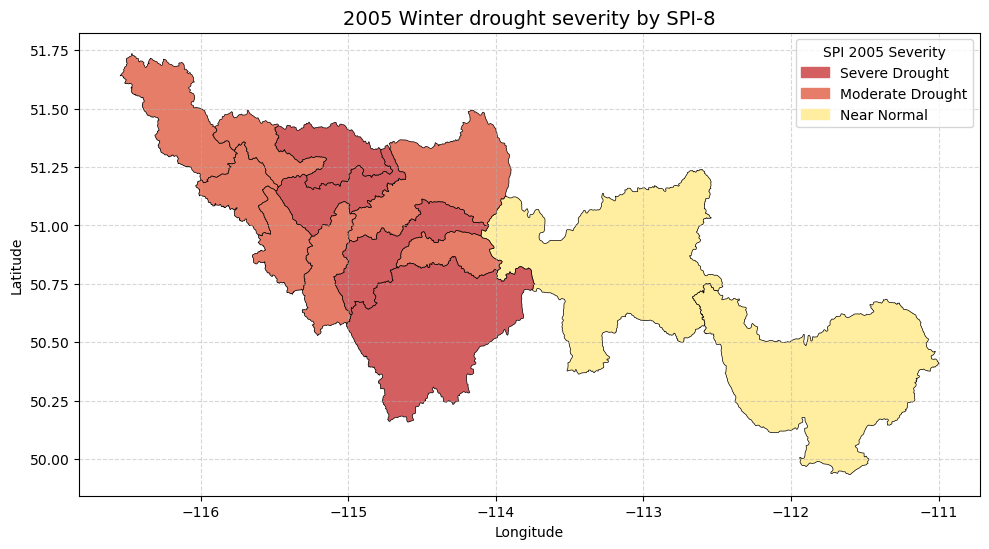

In [73]:
# Filter SPI for 2005 and plot drought severity on Bow Basin
# Assumes spi_df, config, sswei, and (optionally) bow_basin, severity_colors already exist in the notebook.

# Ensure bow_basin is available
if 'bow_basin' not in globals():
    bow_basin = gpd.read_file(config['shapefile_dir'])

# get SPI row for season 2005
season = 2005
if season in spi_df.index:
    spi_2005 = spi_df.loc[season]
else:
    # if index is not integer-indexed, try to find by value in index column
    try:
        spi_2005 = spi_df.reset_index().query("Season_year == @season").set_index('Season_year').loc[season].squeeze()
    except Exception:
        raise KeyError(f"SPI for season {season} not found in spi_df")

# prepare elevation -> SPI and classification maps
elevations = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']
elev_spi_map = {}
elev_class_map = {}
for elev in elevations:
    col = f"{elev}_SPI"
    val = spi_2005[col] if col in spi_2005.index else (spi_2005[col] if isinstance(spi_2005, pd.Series) and col in spi_2005.index else np.nan)
    try:
        val = float(val)
    except Exception:
        val = np.nan
    elev_spi_map[elev] = val
    elev_class_map[elev] = sswei.classify_drought(val) if not np.isnan(val) else None

# add numeric SPI and classification to shapefile using its elevation field (assumed 'elev_class')
bow_basin = bow_basin.copy()
bow_basin['SPI_2005'] = bow_basin['elev_class'].map(elev_spi_map)
bow_basin['SPI_2005_Class'] = bow_basin['elev_class'].map(elev_class_map)

# severity color map (use existing if available)
if 'severity_colors' not in globals():
    severity_colors = {
        'Exceptional Drought': '#800026',
        'Extreme Drought': '#BD0026',
        'Severe Drought': "#D45F61",
        'Moderate Drought': "#E67D68",
        'Near Normal': '#FFEDA0',
        'Abnormally Wet': '#41B6C4',
        'Moderately Wet': '#1E90FF',
        'Very Wet': '#225EA8',
        'Extremely Wet': '#081D58'
    }

bow_basin['color'] = bow_basin['SPI_2005_Class'].map(severity_colors).fillna('#dddddd')

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
bow_basin.plot(ax=ax, color=bow_basin['color'], edgecolor='black', linewidth=0.5)

# create legend for present severities
present = [s for s in severity_colors.keys() if s in bow_basin['SPI_2005_Class'].unique()]
patches = [mpatches.Patch(color=severity_colors[s], label=s) for s in present]
if patches:
    plt.legend(handles=patches, title='SPI 2005 Severity', loc='upper right', frameon=True)

plt.title(f'2005 Winter drought severity by SPI-8', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

out_file = config['plots'] / f'bow_basin_SPI_severity_{season}.png'
fig.savefig(out_file, dpi=150)
print(f"Saved SPI severity map to: {out_file}")
plt.show()

# Comparison

In [7]:
SWEI = pd.read_csv(config['output_dir'] / 'SWEI_final.csv')
SPI = pd.read_csv(config['output_dir'] / 'SPI_final.csv')
SnoDRI = pd.read_csv(config['output_dir'] / 'SnoDRI_final.csv')

# rename season_year column to Season_year for merging
SWEI = SWEI.rename(columns={'season_year': 'Season_year'})
SPI = SPI.rename(columns={'season_year': 'Season_year'})
SnoDRI = SnoDRI.rename(columns={'season_year': 'Season_year'})

# Merge the three DataFrames on 'Season_year'
comparison_df = SWEI.merge(SPI, on='Season_year', how='outer').merge(SnoDRI, on='Season_year', how='outer')
comparison_df = comparison_df.sort_values(by='Season_year').reset_index(drop=True)

# drop classification columns
cols_to_drop = [col for col in comparison_df.columns if 'Classification' in col]
comparison_df = comparison_df.drop(columns=cols_to_drop)
display(comparison_df)

,Season_year,1000_1500m,1500_2000m,2000_2500m,500_1000m,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI,1000_1500m_SnoDRI_z,1500_2000m_SnoDRI_z,2000_2500m_SnoDRI_z,500_1000m_SnoDRI_z
0,1980,-0.778473,-0.630553,-0.346771,-0.087648,0.838107,0.979624,0.527859,1.137794,0.069416,0.299133,0.385759,0.324725
1,1981,0.320094,-0.022423,0.090731,0.605933,-0.447007,-1.056778,-0.489698,0.302220,-0.372589,-0.637686,-0.410053,-0.130155
2,1982,-0.942805,-0.050002,0.072459,0.618429,-0.746335,-0.808827,-1.396826,-0.641098,-0.174939,-0.230560,-0.368458,0.171695
3,1983,-0.358285,-0.266688,-0.307029,0.474398,-1.172533,-1.136674,-1.109690,-0.833213,-0.689634,-0.609202,-0.559459,-0.458039
4,1984,-0.147442,0.176385,-0.214268,0.994070,-1.696451,-1.231230,-1.378387,-0.115584,-0.571142,-0.492565,-0.677126,0.105889
5,1985,0.314323,0.575974,0.860058,1.250473,-0.574501,-0.544821,0.204682,-0.601074,-0.008852,0.135145,0.254739,-0.130533
6,1986,-0.474813,0.062905,0.006162,0.569811,-2.159259,-1.834958,-1.096205,-1.337724,-0.098288,-0.018142,-0.120664,0.389936
7,1987,-1.338402,-0.326762,-0.616191,0.386472,-2.552108,-2.036559,-1.100057,-2.619651,-0.639893,-0.530283,-0.496443,-0.576188
8,1988,0.898300,1.037102,0.378059,1.295822,-0.846069,-0.683786,-0.757280,-0.670248,-0.122259,-0.076731,-0.108300,-0.146040
9,1989,0.113604,1.057718,1.412421,1.065104,0.707024,1.541569,1.090121,0.007406,-0.061543,0.298810,0.659205,-0.131575


In [10]:
# Normalize numeric columns to range [-1, 1] (exclude Season_year)
comparison_df = comparison_df.copy()
num_cols = comparison_df.select_dtypes(include=[np.number]).columns.tolist()
if 'Season_year' in num_cols:
    num_cols.remove('Season_year')

for col in num_cols:
    s = pd.to_numeric(comparison_df[col], errors='coerce')
    valid = s.notna()
    if not valid.any():
        comparison_df[col] = np.nan
        continue
    mn = s[valid].min()
    mx = s[valid].max()
    if np.isclose(mx, mn):
        comparison_df.loc[valid, col] = 0.0
    else:
        comparison_df.loc[valid, col] = -1.0 + 2.0 * (s[valid] - mn) / (mx - mn)

print("Normalized numeric columns to [-1, 1]:", num_cols)
display(comparison_df.head())


Normalized numeric columns to [-1, 1]: ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m', '1000_1500m_SPI', '1500_2000m_SPI', '2000_2500m_SPI', '500_1000m_SPI', '1000_1500m_SnoDRI_z', '1500_2000m_SnoDRI_z', '2000_2500m_SnoDRI_z', '500_1000m_SnoDRI_z']


,Season_year,1000_1500m,1500_2000m,2000_2500m,500_1000m,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI,1000_1500m_SnoDRI_z,1500_2000m_SnoDRI_z,2000_2500m_SnoDRI_z,500_1000m_SnoDRI_z
0,1980,-0.579673,-0.267891,-0.187716,0.114915,0.466220,0.637528,0.118003,0.598517,0.193170,0.597115,0.355051,0.252330
1,1981,0.007238,0.090210,0.056934,0.558639,-0.089574,-0.468063,-0.380334,0.243041,-0.501630,-1.000000,-0.433453,-0.319513
2,1982,-0.667467,0.073970,0.046716,0.566633,-0.219029,-0.333447,-0.824588,-0.158271,-0.190938,-0.305921,-0.392240,0.059952
3,1983,-0.355187,-0.053627,-0.165493,0.474488,-0.403353,-0.511440,-0.683967,-0.240002,-1.000000,-0.951439,-0.581487,-0.731706
4,1984,-0.242544,0.207279,-0.113621,0.806952,-0.629940,-0.562776,-0.815558,0.065297,-0.813739,-0.752595,-0.698073,-0.022775


Saved comparison timeseries figure to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\comparison_timeseries_by_elevation.png


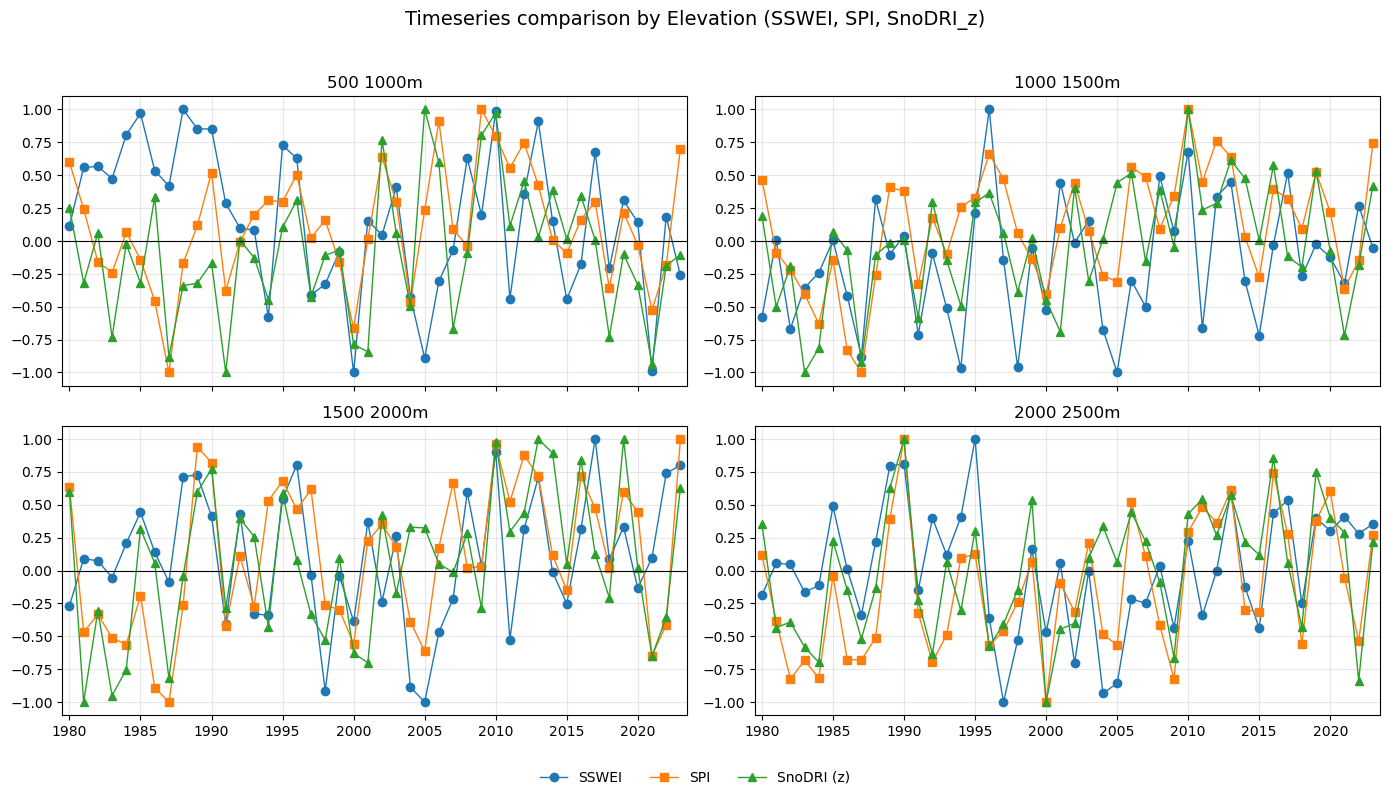

In [11]:
# Timeseries comparison per elevation (order: 500-1000, 1000-1500, 1500-2000, 2000-2500)
elev_order = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']
n = len(elev_order)
ncols = 2
nrows = (n + 1) // 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 8), sharex=True)
axes_flat = axes.flatten() if hasattr(axes, "flatten") else [axes]

x = comparison_df['Season_year']

for i, elev in enumerate(elev_order):
    ax = axes_flat[i]
    sswei_col = elev
    spi_col = f"{elev}_SPI"
    snodri_col = f"{elev}_SnoDRI_z"

    plotted = False
    if sswei_col in comparison_df.columns:
        ax.plot(x, comparison_df[sswei_col], label='SSWEI', color='#1f77b4', marker='o', lw=1)
        plotted = True
    if spi_col in comparison_df.columns:
        ax.plot(x, comparison_df[spi_col], label='SPI', color='#ff7f0e', marker='s', lw=1)
        plotted = True
    if snodri_col in comparison_df.columns:
        ax.plot(x, comparison_df[snodri_col], label='SnoDRI (z)', color='#2ca02c', marker='^', lw=1)
        plotted = True

    if not plotted:
        ax.text(0.5, 0.5, f'No data for {elev}', transform=ax.transAxes, ha='center', va='center')

    ax.set_title(elev.replace('_', ' '))
    ax.axhline(0, color='k', lw=0.8, linestyle='-')
    ax.grid(alpha=0.3)
    ax.set_xlim(x.min() - 0.5, x.max() + 0.5)

# hide any unused axes
for j in range(len(elev_order), len(axes_flat)):
    axes_flat[j].set_visible(False)

# global legend and layout
handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False)
fig.suptitle('Timeseries comparison by Elevation (SSWEI, SPI, SnoDRI_z)', fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])

out_file = config['plots'] / 'comparison_timeseries_by_elevation.png'
fig.savefig(out_file, dpi=150)
print(f"Saved comparison timeseries figure to: {out_file}")
plt.show()

In [143]:
# Load and filter SWEI, SPI, SnoDRI CSVs for season 2005, then save/display the filtered subsets.
paths = {
    'SWEI': config['output_dir'] / 'monthly_SWEI_2005_long.csv',
    'SPI':  config['output_dir'] / 'monthly_SPI_2005.csv',
    'SnoDRI': config['output_dir'] / 'sel_season_2005.csv'
}

SWEI_2005 = pd.read_csv(paths['SWEI'])
SPI_2005 = pd.read_csv(paths['SPI'])
SnoDRI_2005 = pd.read_csv(paths['SnoDRI'])
# Display and save each filtered DataFrame
for name, df in zip(['SWEI', 'SPI', 'SnoDRI'], [SWEI_2005, SPI_2005, SnoDRI_2005]):
    print(f"\n{name} for season 2005:")
    display(df.head())
   


SWEI for season 2005:


,month,1000_1500m,1500_2000m,2000_2500m,500_1000m
0,1,-0.082649,-0.070957,0.245064,0.417232
1,2,0.627864,0.169559,0.427731,0.429899
2,3,1.463092,1.422198,1.456277,1.478063
3,4,-0.618158,-0.341891,0.558838,-0.767177
4,5,-1.409226,-1.219167,-0.925401,-1.353153



SPI for season 2005:


,Season_year,Elevation_Category,month,month_label,Precipitation,SPI
0,2005,1000_1500m,10,Oct,19.361433,-0.052669
1,2005,1000_1500m,11,Nov,16.813028,0.131721
2,2005,1000_1500m,12,Dec,4.272242,-1.209708
3,2005,1000_1500m,1,Jan,7.627983,-0.349224
4,2005,1000_1500m,2,Feb,16.604584,0.466405



SnoDRI for season 2005:


,Elevation_Category,season_year,month_end,Precipitation,Mean_Temp,Humidity,snow_fraction,Flux,Vwind,spi3,...,Mean_Temp_z,Humidity_z,snow_fraction_z,Flux_z,Vwind_z,spi3_z,spi4_z,spi6_z,SnoDRI,SnoDRI_z
0,1000_1500m,2005,2005-10-31,19.361433,4.706605,0.004280,0.868738,107.240724,0.745844,1.414789,...,1.152935,1.500307,-1.264760,-0.202279,1.347712,2.526569,2.068281,3.040028,12.275158,2.769762
1,500_1000m,2005,2005-10-31,18.897848,6.048613,0.004608,0.867900,111.944053,2.187067,1.917584,...,1.350349,1.818395,-1.495423,-0.137150,3.659198,3.194677,2.820281,3.194533,15.786015,3.561950
2,1500_2000m,2005,2005-10-31,27.055029,3.112518,0.003952,0.869677,108.343599,0.492389,1.118791,...,0.918441,1.181996,-1.006077,-0.187007,0.941212,2.133251,1.791455,3.205830,11.546306,2.605304
3,2000_2500m,2005,2005-10-31,49.888281,-1.705637,0.003502,0.872000,102.668002,0.359709,1.259880,...,0.209676,0.744923,-0.366668,-0.265601,0.728415,2.320729,2.166201,3.045895,11.255020,2.539578
4,1000_1500m,2005,2005-11-30,16.813028,-0.243758,0.002684,0.872227,60.999317,-0.741349,0.548991,...,0.424723,-0.048284,-0.304342,-0.842613,-1.037502,1.376108,2.024579,2.972265,7.395181,1.668646


In [172]:
# Unstack SPI for 2005 by elevation and drop Precipitation
if 'spi_2005_aligned' not in globals():
    raise NameError("spi_2005_aligned not found. Run the previous cells that create it first.")

df = SPI_2005.copy()

# drop precipitation column if present
if 'Precipitation' in df.columns:
    df = df.drop(columns=['Precipitation'])

# choose month_label column (prefer month_label_spi if present)
month_label_col = 'month_label_spi' if 'month_label_spi' in df.columns else 'month_label'
index_cols = ['Season_year', 'month', month_label_col]

# pivot to wide format: one SPI column per Elevation_Category
spi_2005_unstacked = df.pivot_table(index=index_cols, columns='Elevation_Category', values='SPI', aggfunc='first')

# flatten columns to e.g. "2000_2500m_SPI"
spi_2005_unstacked.columns = [f"{c}_SPI" for c in spi_2005_unstacked.columns]

# reset index for easy viewing/saving and order months Oct->May
spi_2005_unstacked = spi_2005_unstacked.reset_index()
months_order = [10, 11, 12, 1, 2, 3, 4, 5]
spi_2005_unstacked['month'] = spi_2005_unstacked['month'].astype(int)
# create ordering key so Oct->May sorts correctly within the season
spi_2005_unstacked['month_order'] = spi_2005_unstacked['month'].apply(lambda m: months_order.index(m) if m in months_order else 999)
spi_2005_unstacked = spi_2005_unstacked.sort_values(['Season_year', 'month_order']).drop(columns=['month_order','Season_year', 'month_label'])

# save and display
out_file = config['output_dir'] / 'monthly_SPI_2005_unstacked.csv'
spi_2005_unstacked.to_csv(out_file, index=False)
print(f"Saved unstacked monthly SPI for 2005 to: {out_file}")

display(spi_2005_unstacked.head(12))

Saved unstacked monthly SPI for 2005 to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SPI_2005_unstacked.csv


,month,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI
5,10,-0.052669,-0.013912,0.549937,0.393079
6,11,0.131721,0.276616,-0.712863,-0.074196
7,12,-1.209708,-1.036021,-1.424022,-0.908139
0,1,-0.349224,-0.382049,0.390312,0.233379
1,2,0.466405,0.035853,-0.213536,0.368217
2,3,-0.891061,-1.640496,-0.784207,0.422021
3,4,-0.159193,-0.427991,0.554801,0.658789
4,5,-0.376534,-0.464000,-0.473230,0.435772


In [173]:

df = SnoDRI_2005.copy()

# drop precipitation column if present
df = df.drop(columns=['Precipitation', 'Mean_Temp', 'Humidity', 'snow_fraction', 'Flux', 'Vwind', 'spi3', 'Mean_Temp_z', 'Humidity_z', 'snow_fraction_z', 'Flux_z', 'Vwind_z', 'spi3_z', 'spi4_z', 'spi6_z', 'SnoDRI'])
# derive month & month_label from month_end if available, otherwise try other date-like columns
if 'month_end' in df.columns:
    df['month_end'] = pd.to_datetime(df['month_end'], errors='coerce')
    df['month'] = df['month_end'].dt.month
    df['month_label'] = df['month_end'].dt.strftime('%b')
else:
    # if month already present but no label, create label
    if 'month' in df.columns and 'month_label' not in df.columns:
        df['month_label'] = df['month'].apply(lambda m: pd.to_datetime(f'2000-{int(m):02d}-01').strftime('%b') if pd.notna(m) else np.nan)
    # try to infer month from any date-like column
    if 'month' not in df.columns:
        for c in df.columns:
            parsed = pd.to_datetime(df[c], errors='coerce')
            if parsed.notna().sum() > 0:
                df['month'] = parsed.dt.month
                df['month_label'] = parsed.dt.strftime('%b')
                break

index_cols = ['season_year', 'month', 'month_label']

# pivot to wide format: one SPI column per Elevation_Category
snodri_2005_unstacked = df.pivot_table(index=index_cols, columns='Elevation_Category', values='SnoDRI_z', aggfunc='first')

# flatten columns to e.g. "2000_2500m_SPI"
snodri_2005_unstacked.columns = [f"{c}_SnoDRI" for c in snodri_2005_unstacked.columns]

# reset index for easy viewing/saving and order months Oct->May
snodri_2005_unstacked = snodri_2005_unstacked.reset_index()
months_order = [10, 11, 12, 1, 2, 3, 4, 5]
snodri_2005_unstacked['month'] = snodri_2005_unstacked['month'].astype(int)
# create ordering key so Oct->May sorts correctly within the season
snodri_2005_unstacked['month_order'] = snodri_2005_unstacked['month'].apply(lambda m: months_order.index(m) if m in months_order else 999)
snodri_2005_unstacked = snodri_2005_unstacked.sort_values(['season_year', 'month_order']).drop(columns=['month_order','season_year', 'month_label'])

# save and display
out_file = config['output_dir'] / 'monthly_SnoDRI_2005_unstacked.csv'
snodri_2005_unstacked.to_csv(out_file, index=False)
print(f"Saved unstacked monthly SnoDRI for 2005 to: {out_file}")
display(snodri_2005_unstacked.head(12))

Saved unstacked monthly SnoDRI for 2005 to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SnoDRI_2005_unstacked.csv


,month,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
5,10,2.769762,2.605304,2.539578,3.561950
6,11,1.668646,1.757924,1.619876,2.093976
7,12,-0.213678,-0.221801,-0.375518,0.430844
0,1,-0.530610,-0.560962,-0.452359,0.360861
1,2,-1.257527,-1.228690,-1.278078,-0.907150
2,3,-1.086706,-1.364560,-1.290957,-0.449877
3,4,-0.179885,-0.390661,-0.369682,0.733632
4,5,0.660790,0.512511,0.323887,1.531504


In [147]:
#merge SWEI_2005, unstacked SPI and SnoDRI for 2005
merged_2005 = SWEI_2005.merge(spi_2005_unstacked, left_on=[ 'month'], right_on=[ 'month'], how='outer')
merged_2005 = merged_2005.merge(snodri_2005_unstacked, left_on=[ 'month'], right_on=[ 'month'], how='outer')
merged_2005 = merged_2005.sort_values(by='month').reset_index(drop=True)
display(merged_2005)

,month,1000_1500m,1500_2000m,2000_2500m,500_1000m,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
0,1,-0.082649,-0.070957,0.245064,0.417232,-0.349224,-0.382049,0.390312,0.233379,-0.530610,-0.560962,-0.452359,0.360861
1,2,0.627864,0.169559,0.427731,0.429899,0.466405,0.035853,-0.213536,0.368217,-1.257527,-1.228690,-1.278078,-0.907150
2,3,1.463092,1.422198,1.456277,1.478063,-0.891061,-1.640496,-0.784207,0.422021,-1.086706,-1.364560,-1.290957,-0.449877
3,4,-0.618158,-0.341891,0.558838,-0.767177,-0.159193,-0.427991,0.554801,0.658789,-0.179885,-0.390661,-0.369682,0.733632
4,5,-1.409226,-1.219167,-0.925401,-1.353153,-0.376534,-0.464000,-0.473230,0.435772,0.660790,0.512511,0.323887,1.531504
5,10,-0.807238,-0.929162,-1.275402,-0.714291,-0.052669,-0.013912,0.549937,0.393079,2.769762,2.605304,2.539578,3.561950
6,11,0.104382,0.099932,-0.524131,-0.149433,0.131721,0.276616,-0.712863,-0.074196,1.668646,1.757924,1.619876,2.093976
7,12,0.721932,0.869488,0.037024,0.658860,-1.209708,-1.036021,-1.424022,-0.908139,-0.213678,-0.221801,-0.375518,0.430844


In [163]:
# Normalize numeric columns in `spi_2005_unstacked` to range [-1, 1], excluding 'month'
merged_2005_norm = merged_2005.copy()

# numeric columns present
num_cols = merged_2005_norm.select_dtypes(include=[np.number]).columns.tolist()
if 'month' in num_cols:
    num_cols.remove('month')

for col in num_cols:
    vals = pd.to_numeric(merged_2005_norm[col], errors='coerce').to_numpy().astype(float)
    valid = ~np.isnan(vals)
    if valid.sum() == 0:
        merged_2005_norm[col] = np.nan
        continue
    # constant column or single valid value -> set valid entries to 0.0
    if valid.sum() == 1 or np.isclose(vals[valid].max(), vals[valid].min()):
        merged_2005_norm.loc[valid, col] = 0.0
        merged_2005_norm.loc[~valid, col] = np.nan
        continue
    # scale valid entries to [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = np.full_like(vals, np.nan, dtype=float)
    scaled[valid] = scaler.fit_transform(vals[valid].reshape(-1, 1)).ravel()
    merged_2005_norm[col] = scaled
# rename columns 1000_1500m	1500_2000m	2000_2500m	500_1000m to 1000_1500m_SWEI	1500_2000m_SWEI	2000_2500m_SWEI	500_1000m_SWEI
# Rename only the first 4 numeric columns that appear after 'month' in column order
cols = merged_2005_norm.columns.tolist()
if 'month' in cols:
    idx = cols.index('month')
    after_month = [c for c in cols[idx+1:] if c in num_cols]
else:
    after_month = [c for c in cols if c in num_cols]

to_rename = after_month[:4]
merged_2005_norm = merged_2005_norm.rename(columns={c: f"{c}_SWEI" for c in to_rename})

# preview
display(merged_2005_norm.head())

,month,1000_1500m_SWEI,1500_2000m_SWEI,2000_2500m_SWEI,500_1000m_SWEI,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
0,1,-0.076302,-0.130593,0.113210,0.250618,0.026761,0.312858,0.833751,0.457015,-0.639004,-0.595151,-0.562151,-0.432543
1,2,0.418429,0.051522,0.246949,0.259566,1.000000,0.748828,0.223440,0.629120,-1.000000,-0.931549,-0.993276,-1.000000
2,3,1.000000,1.000000,1.000000,1.000000,-0.619779,-1.000000,-0.353338,0.697794,-0.915168,-1.000000,-1.000000,-0.795362
3,4,-0.449178,-0.335741,0.342940,-0.586061,0.253513,0.264929,1.000000,1.000000,-0.464830,-0.509354,-0.518984,-0.265722
4,5,-1.000000,-1.000000,-0.743747,-1.000000,-0.005826,0.227363,-0.039033,0.715345,-0.047340,-0.054340,-0.156857,0.091340


2025-11-06 21:32:27,528 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 21:32:27,530 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 21:32:27,534 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 21:32:27,537 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 21:32:27,539 - INFO - Using categorical units to plot a list of strings that are all parsable as 

Saved figure to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\merged_2005_by_elevation_oct_may.png


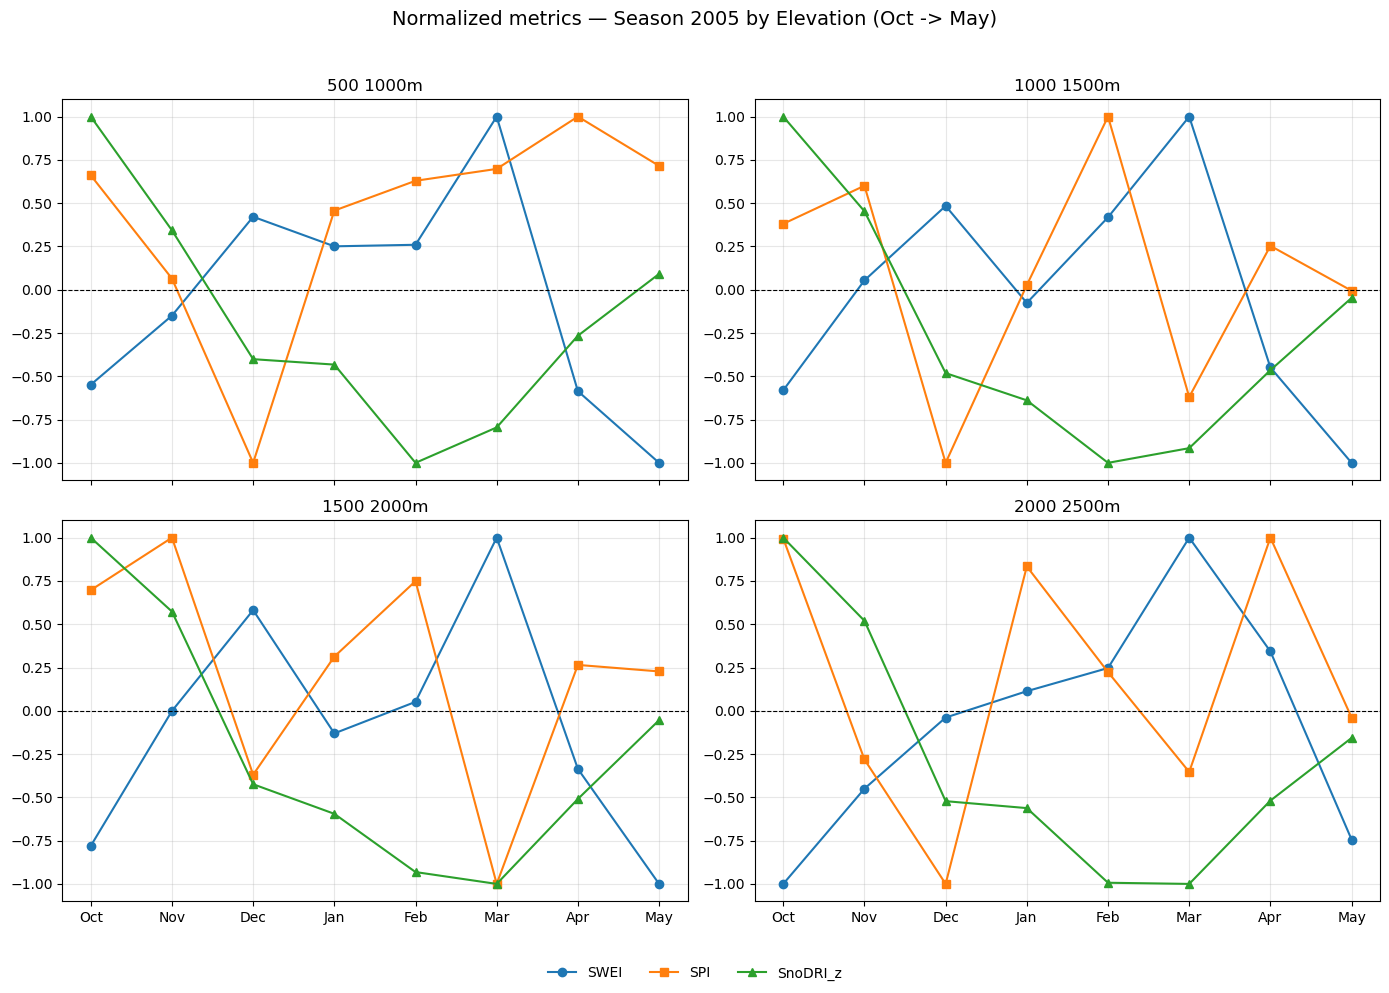

In [165]:
# Plot merged_2005_norm: 4 subplots (one per elevation) showing Oct->May
if 'merged_2005_norm' not in globals():
    raise NameError("merged_2005_norm not found. Run the cell that creates it first.")

month_order = [10, 11, 12, 1, 2, 3, 4, 5]
month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
elev_order = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

color_map = {'SWEI': '#1f77b4', 'SPI': '#ff7f0e', 'SnoDRI_z': '#2ca02c'}
marker_map = {'SWEI': 'o', 'SPI': 's', 'SnoDRI_z': '^'}

def fetch_series(df, elev, metric):
    # try wide column names first (e.g. "1000_1500m_SPI" or "1000_1500m_SPI_norm")
    wide_candidates = [
        f"{elev}_{metric}",
        f"{elev}_{metric}_norm",
        f"{elev}_{metric.replace('SnoDRI_z','SnoDRI')}",  # tolerant fallback
    ]
    for c in wide_candidates:
        if c in df.columns:
            return df.set_index('month').reindex(month_order)[c].values

    # otherwise try long form: filter by Elevation_Category and use metric (or metric_norm)
    if 'Elevation_Category' in df.columns:
        sub = df[df['Elevation_Category'] == elev].set_index('month').reindex(month_order)
        for c in [f"{metric}_norm", metric]:
            if c in sub.columns:
                return sub[c].values
    # not found -> return array of NaNs
    return np.full(len(month_order), np.nan)

for ax, elev in zip(axes, elev_order):
    plotted = False
    for metric in ['SWEI', 'SPI', 'SnoDRI_z']:
        y = fetch_series(merged_2005_norm, elev, metric)
        if not np.all(np.isnan(y)):
            ax.plot(month_labels, y, marker=marker_map.get(metric, 'o'),
                    label=metric, color=color_map.get(metric, None), lw=1.5)
            plotted = True
    if not plotted:
        ax.text(0.5, 0.5, f'No data for {elev}', transform=ax.transAxes, ha='center', va='center')
    ax.set_title(elev.replace('_', ' '))
    ax.axhline(0, color='k', lw=0.8, linestyle='--')
    ax.grid(alpha=0.3)

# hide any unused axes
for j in range(len(elev_order), len(axes)):
    axes[j].set_visible(False)

# global legend
handles, labels = [], []
for a in axes:
    h, l = a.get_legend_handles_labels()
    for hh, ll in zip(h, l):
        if ll not in labels:
            handles.append(hh); labels.append(ll)
if handles:
    fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False)

fig.suptitle('Normalized metrics — Season 2005 by Elevation (Oct -> May)', fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])
out_file = config['plots'] / 'merged_2005_by_elevation_oct_may.png'
fig.savefig(out_file, dpi=150)
print(f"Saved figure to: {out_file}")
plt.show()

In [167]:
import calendar

# Merge SSWEI, SPI and SnoDRI on Season_year, Elevation_Category and month; keep only relevant columns.


# copies to avoid modifying originals
swei = swei_2005.copy()
spi = spi_2005.copy()
snodri = snodri_2005.copy()

# ensure month exists in snodri (extract from month_end if necessary)
if 'month' not in snodri.columns:
    if 'month_end' in snodri.columns:
        snodri['month'] = pd.to_datetime(snodri['month_end'], errors='coerce').dt.month
    else:
        # try to infer from any date-like column
        for c in snodri.columns:
            if snodri[c].dtype == object:
                parsed = pd.to_datetime(snodri[c], errors='coerce')
                if parsed.notna().sum() > 0:
                    snodri['month'] = parsed.dt.month
                    break

# select minimal columns to merge / keep
swei_sel = swei[['Season_year', 'Elevation_Category', 'month', 'month_label', 'SSWEI']].copy()
spi_sel = spi[['Season_year', 'Elevation_Category', 'month', 'Precipitation', 'SPI']].copy()
snodri_sel = snodri[['Season_year', 'Elevation_Category', 'month', 'SnoDRI', 'SnoDRI_z']].copy()

# perform merges (outer to retain any rows present in any source)
merged = pd.merge(swei_sel, spi_sel, on=['Season_year', 'Elevation_Category', 'month'], how='outer', validate='1:1', suffixes=('_swei', '_spi'))
merged = pd.merge(merged, snodri_sel, on=['Season_year', 'Elevation_Category', 'month'], how='outer', validate='1:1')

# ensure there is a month_label (prefer existing, else create from month)
if 'month_label' not in merged.columns or merged['month_label'].isna().any():
    merged['month_label'] = merged['month'].apply(lambda m: calendar.month_abbr[int(m)] if pd.notna(m) else np.nan)

# drop any remaining unnecessary raw columns if present
drop_candidates = [
    'month_end', 'time', 'Mean_Temp', 'Max_Temp', 'Humidity', 'snow_fraction',
    'Flux', 'Vwind', 'spi3', 'spi4', 'spi6', 'Precipitation_z', 'Mean_Temp_z',
    'Humidity_z', 'snow_fraction_z', 'Flux_z', 'Vwind_z', 'spi3_z', 'spi4_z', 'spi6_z','SnoDRI','Precipitation'
]
to_drop = [c for c in drop_candidates if c in merged.columns]
if to_drop:
    merged = merged.drop(columns=to_drop)

# reorder columns for readability
cols_order = ['Season_year', 'month', 'month_label', 'Elevation_Category', 'SSWEI', 'SPI', 'Precipitation', 'SnoDRI', 'SnoDRI_z']
final_cols = [c for c in cols_order if c in merged.columns] + [c for c in merged.columns if c not in cols_order]
merged = merged[final_cols]

# save merged result
out_file = config['output_dir'] / 'merged_by_elevation_month_2005.csv'
merged.to_csv(out_file, index=False)

print(f"Merged {len(merged)} rows; saved to {out_file}")
display(merged.head())

Merged 32 rows; saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\merged_by_elevation_month_2005.csv


,Season_year,month,month_label,Elevation_Category,SSWEI,SPI,SnoDRI_z
0,2005,1,Jan,1000_1500m,-0.971672,-0.349224,-0.530610
1,2005,1,Jan,1500_2000m,-1.459747,-0.382049,-0.560962
2,2005,1,Jan,2000_2500m,-1.290024,0.390312,-0.452359
3,2005,1,Jan,500_1000m,-1.073578,0.233379,0.360861
4,2005,2,Feb,1000_1500m,0.817519,0.466405,-1.257527


In [168]:
# Unstack `merged` dataframe so each Elevation_Category becomes columns (wide format)
if 'merged' not in globals():
    raise NameError("merged dataframe not found. Run the merge cell (cell 42) first.")

# choose index and metric columns
index_cols = ['Season_year', 'month', 'month_label']
if not all(c in merged.columns for c in index_cols + ['Elevation_Category']):
    raise KeyError("merged is missing required columns (Season_year, month, month_label, Elevation_Category)")

metric_cols = [c for c in merged.columns if c not in index_cols + ['Elevation_Category']]
if not metric_cols:
    raise ValueError("No metric columns found to unstack in merged dataframe")

# pivot to wide: metrics x elevation -> columns will be MultiIndex (metric, Elevation_Category)
merged_wide = merged.pivot_table(index=index_cols, columns='Elevation_Category', values=metric_cols, aggfunc='first')

# flatten MultiIndex columns to 'metric_elevation' naming
if isinstance(merged_wide.columns, pd.MultiIndex):
    merged_wide.columns = [f"{metric}_{elev}" for metric, elev in merged_wide.columns]
else:
    # single metric case: columns are elevation categories -> prefix with metric name
    merged_wide.columns = [f"{metric_cols[0]}_{c}" for c in merged_wide.columns]

# reset index to turn Season_year/month back into columns
merged_unstacked = merged_wide.reset_index().sort_values(index_cols).reset_index(drop=True)

# save and display
out_file = config['output_dir'] / 'merged_unstacked_by_elevation.csv'
merged_unstacked.to_csv(out_file, index=False)
print(f"Saved unstacked merged dataframe to: {out_file}")
display(merged_unstacked.head())

Saved unstacked merged dataframe to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\merged_unstacked_by_elevation.csv


,Season_year,month,month_label,SPI_1000_1500m,SPI_1500_2000m,SPI_2000_2500m,SPI_500_1000m,SSWEI_1000_1500m,SSWEI_1500_2000m,SSWEI_2000_2500m,SSWEI_500_1000m,SnoDRI_z_1000_1500m,SnoDRI_z_1500_2000m,SnoDRI_z_2000_2500m,SnoDRI_z_500_1000m
0,2005,1,Jan,-0.349224,-0.382049,0.390312,0.233379,-0.971672,-1.459747,-1.290024,-1.073578,-0.530610,-0.560962,-0.452359,0.360861
1,2005,2,Feb,0.466405,0.035853,-0.213536,0.368217,0.817519,-0.370931,-1.383112,0.032467,-1.257527,-1.228690,-1.278078,-0.907150
2,2005,3,Mar,-0.891061,-1.640496,-0.784207,0.422021,-0.546499,-0.647179,-1.527944,-0.998264,-1.086706,-1.364560,-1.290957,-0.449877
3,2005,4,Apr,-0.159193,-0.427991,0.554801,0.658789,-1.214669,-1.331006,-1.539571,-1.350008,-0.179885,-0.390661,-0.369682,0.733632
4,2005,5,May,-0.376534,-0.464000,-0.473230,0.435772,-1.179104,-0.118738,-0.176703,-1.473794,0.660790,0.512511,0.323887,1.531504


In [169]:
if 'merged_unstacked' not in globals():
    raise NameError("merged_unstacked not found. Run the previous cells that create it first.")

merged_unstacked_norm = merged_unstacked.copy()
num_cols = merged_unstacked_norm.select_dtypes(include=[np.number]).columns.tolist()

for col in num_cols:
    s = pd.to_numeric(merged_unstacked_norm[col], errors='coerce')
    valid = s.notna()
    if not valid.any():
        merged_unstacked_norm[col] = np.nan
        continue
    mn = s[valid].min()
    mx = s[valid].max()
    if np.isclose(mx, mn):
        # constant column -> set to 0 for valid entries
        merged_unstacked_norm.loc[valid, col] = 0.0
    else:
        merged_unstacked_norm.loc[valid, col] = -1.0 + 2.0 * (s[valid] - mn) / (mx - mn)

# save normalized result
out_file = config['output_dir'] / 'merged_unstacked_normalized.csv'
merged_unstacked_norm.to_csv(out_file, index=False)
print(f"Normalized {len(num_cols)} numeric columns and saved to: {out_file}")

# show a preview
display(merged_unstacked_norm.head())

Normalized 14 numeric columns and saved to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\merged_unstacked_normalized.csv


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37196\2701836497.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.         -0.81818182 -0.63636364 -0.45454545 -0.27272727  0.63636364
  0.81818182  1.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_unstacked_norm.loc[valid, col] = -1.0 + 2.0 * (s[valid] - mn) / (mx - mn)


,Season_year,month,month_label,SPI_1000_1500m,SPI_1500_2000m,SPI_2000_2500m,SPI_500_1000m,SSWEI_1000_1500m,SSWEI_1500_2000m,SSWEI_2000_2500m,SSWEI_500_1000m,SnoDRI_z_1000_1500m,SnoDRI_z_1500_2000m,SnoDRI_z_2000_2500m,SnoDRI_z_500_1000m
0,0,-1.000000,Jan,0.026761,0.312858,0.833751,0.457015,-0.707386,-0.924902,-0.633791,-0.468597,-0.639004,-0.595151,-0.562151,-0.432543
1,0,-0.818182,Feb,1.000000,0.748828,0.223440,0.629120,1.000000,0.429983,-0.770397,1.000000,-1.000000,-0.931549,-0.993276,-1.000000
2,0,-0.636364,Mar,-0.619779,-1.000000,-0.353338,0.697794,-0.301653,0.086230,-0.982938,-0.368596,-0.915168,-1.000000,-1.000000,-0.795362
3,0,-0.454545,Apr,0.253513,0.264929,1.000000,1.000000,-0.939273,-0.764701,-1.000000,-0.835638,-0.464830,-0.509354,-0.518984,-0.265722
4,0,-0.272727,May,-0.005826,0.227363,-0.039033,0.715345,-0.905334,0.743804,1.000000,-1.000000,-0.047340,-0.054340,-0.156857,0.091340


2025-11-06 22:02:04,032 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 22:02:04,035 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 22:02:04,037 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 22:02:04,040 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 22:02:04,042 - INFO - Using categorical units to plot a list of strings that are all parsable as 

Saved figure to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\merged_monthly_2005_by_elevation.png


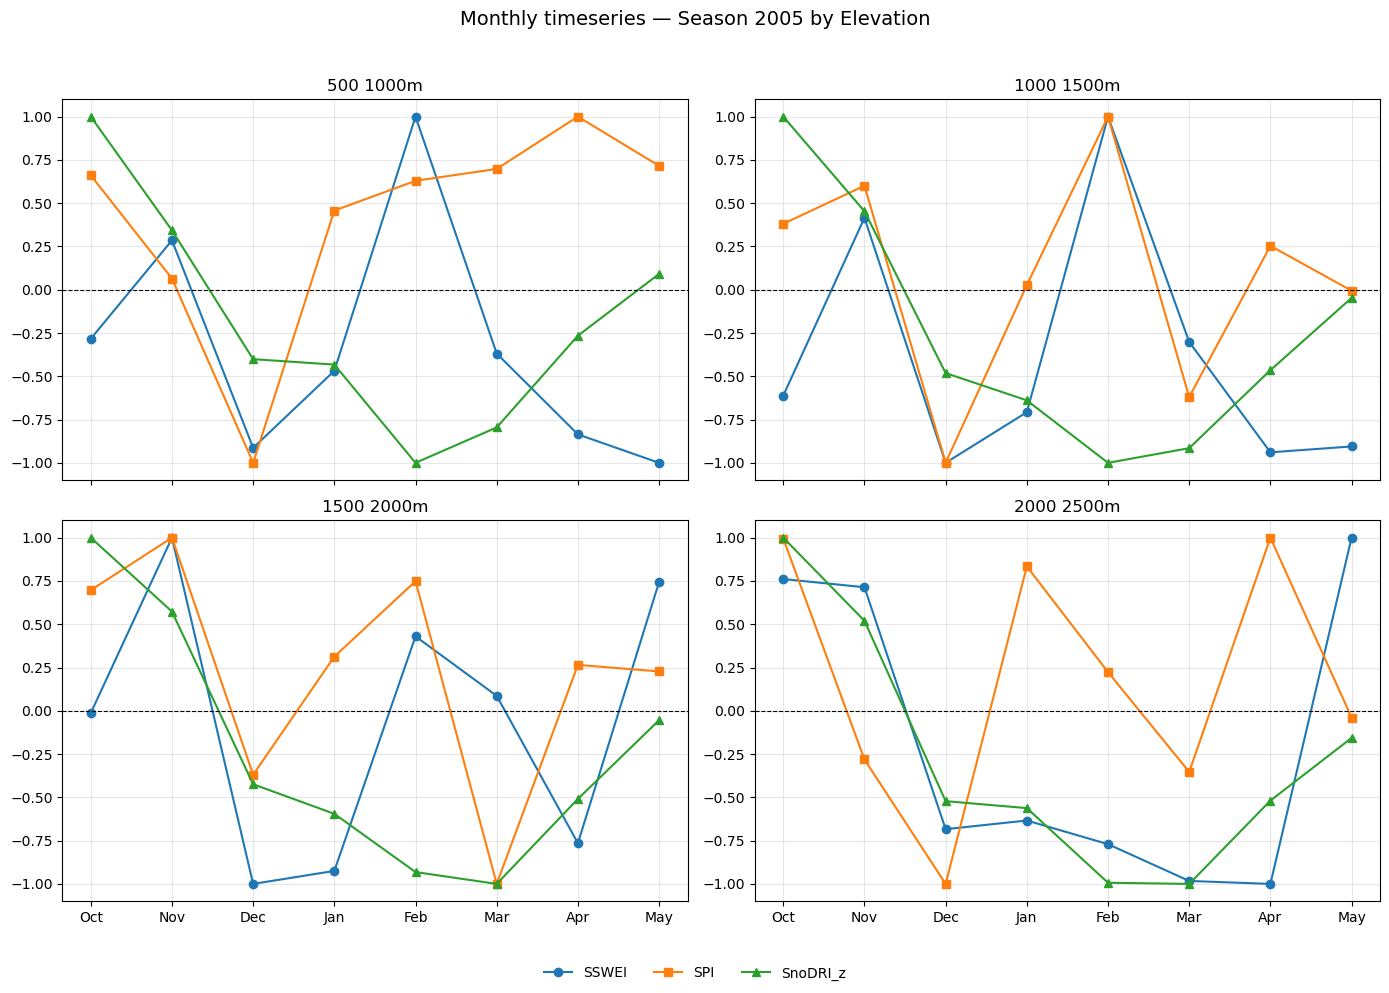

In [170]:
# Plot monthly timeseries for 2005 using the merged (long) dataframe.
# merged_norm created earlier is wide and may not contain 'Elevation_Category' -> prefer the long `merged` produced in cell 42.
season = 2005
month_order = [10, 11, 12, 1, 2, 3, 4, 5]
month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
elev_order = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']

# Prefer the long merged dataframe which has Elevation_Category; fall back to merged_norm only if necessary.
if 'merged' in globals():
    merged_src = merged.copy()
elif 'merged_norm' in globals() and 'Elevation_Category' in merged_unstacked_norm.columns:
    merged_src = merged_unstacked_norm.copy()
else:
    raise NameError("No suitable merged dataframe found with 'Elevation_Category'. Run the merge cell (cell 42) first.")

merged_2005 = merged_src[merged_src['Season_year'] == season].copy()
if merged_2005.empty:
    raise ValueError(f"No rows for Season_year == {season} in merged dataframe")

# Ensure normalized columns exist for plotting. Create per-elevation normalization to [-1,1] if needed.
metrics = ['SSWEI', 'SPI', 'SnoDRI_z']
scaler = MinMaxScaler(feature_range=(-1, 1))
for metric in metrics:
    norm_col = f"{metric}_norm"
    # create column if missing
    if metric not in merged_2005.columns:
        merged_2005[norm_col] = np.nan
        continue
    if norm_col not in merged_2005.columns:
        merged_2005[norm_col] = np.nan

    for elev in merged_2005['Elevation_Category'].unique():
        mask = merged_2005['Elevation_Category'] == elev
        vals = merged_2005.loc[mask, metric].astype(float).values
        valid = ~np.isnan(vals)
        if valid.sum() == 0:
            merged_2005.loc[mask, norm_col] = np.nan
        elif valid.sum() == 1:
            merged_2005.loc[mask, norm_col] = 0.0
        else:
            try:
                scaled = np.full_like(vals, np.nan, dtype=float)
                scaled_valid = scaler.fit_transform(vals[valid].reshape(-1, 1)).ravel()
                scaled[valid] = scaled_valid
                merged_2005.loc[mask, norm_col] = scaled
            except Exception:
                s = pd.Series(vals)
                z = (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0) != 0 else 1.0)
                merged_2005.loc[mask, norm_col] = np.clip(z, -1, 1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=False)
axes = axes.flatten()

for ax, elev in zip(axes, elev_order):
    df_e = (
        merged_2005[merged_2005['Elevation_Category'] == elev]
        .set_index('month')
        .reindex(month_order)
    )

    plotted = False
    if 'SSWEI_norm' in df_e.columns and df_e['SSWEI_norm'].notna().any():
        ax.plot(month_labels, df_e['SSWEI_norm'].values, marker='o', label='SSWEI', color='#1f77b4')
        plotted = True
    if 'SPI_norm' in df_e.columns and df_e['SPI_norm'].notna().any():
        ax.plot(month_labels, df_e['SPI_norm'].values, marker='s', label='SPI', color='#ff7f0e')
        plotted = True
    if 'SnoDRI_z_norm' in df_e.columns and df_e['SnoDRI_z_norm'].notna().any():
        ax.plot(month_labels, df_e['SnoDRI_z_norm'].values, marker='^', label='SnoDRI_z', color='#2ca02c')
        plotted = True

    if not plotted:
        ax.text(0.5, 0.5, f'No series for {elev}', transform=ax.transAxes, ha='center', va='center')

    ax.set_title(elev.replace('_', ' '))
    ax.axhline(0, color='k', lw=0.8, linestyle='--')
    ax.grid(alpha=0.3)

# global legend (gather from all axes)
handles = []
labels = []
for a in axes:
    h, l = a.get_legend_handles_labels()
    for hh, ll in zip(h, l):
        if ll not in labels:
            handles.append(hh); labels.append(ll)

fig.legend(handles, labels, loc='lower center', ncol=4, frameon=False)
fig.suptitle(f'Monthly timeseries — Season {season} by Elevation', fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])

out_file = config['plots'] / f'merged_monthly_{season}_by_elevation.png'
fig.savefig(out_file, dpi=150)
print(f"Saved figure to: {out_file}")
plt.show()